# Data Analytics in Healthcare and Connected Care
## Vrije Universiteit Brussel



#Part 1 Data Storing

Our files in google drive:https://drive.google.com/drive/folders/1Rlaytp62Y-jeCtnEo8ozG_cYqfhIrpjD?usp=share_link

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sklearn 
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix, auc, classification_report, cohen_kappa_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay


In [ ]:
path = '/content/drive/MyDrive/DA_Project'

In [ ]:
features = ['heart_rate','systolic_blood_pressure','diastolic_blood_pressure','mean_blood_pressure','respiratory_rate','saturation_pulse_oxygen','body_temperature',
            'Red_Blood_Cells', 'MCH', 'MCHC', 'MCV',
            'RDW', 'Neutrophils', 'Basophils', 'Hematocrit', 'Platelet_Count','White_Blood_Cells',
            'lymphocytes', 'prothrombin_time', 'international_normalised_ratio', 'NT-proBNP',
            'creatine_kinase', 'creatinine', 'potassium', 'sodium', 'calcium', 'chloride', 'magnesium',
            'the_anion_gap', 'bicarbonate', 'lactate', 'pH', 'partial_pressure_CO2_in_arterial_blood']

#Part 2 Preprocessing Data

Our data can be classified into four distinct feature categories, each of which requires a specific processing method. Once all of the data has been processed, we combine the resulting sets to create our final dataset.

##Demographic Characteristics

In this step we delete ICUSTAY_ID', 'LOS columns and calculate the age from the date of birth

In [ ]:
patients = pd.read_csv("/content/drive/MyDrive/DA_Project/hadm_records.csv")
patients.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,GENDER,ETHNICITY,DOB,EXPIRE_FLAG,ADMITTIME,LOS
0,56,181711,275642,F,WHITE,1804-01-02 00:00:00,1,2104-01-02 02:01:00,1.8492
1,25147,106000,277318,F,WHITE,2059-08-18 00:00:00,1,2128-01-11 17:02:00,4.9646
2,17863,148295,205992,F,WHITE,2062-11-13 00:00:00,1,2144-01-28 20:18:00,18.2774
3,19267,117996,213557,F,WHITE,2107-08-19 00:00:00,1,2188-02-22 16:28:00,2.0126
4,19334,183582,275392,F,PATIENT DECLINED TO ANSWER,2041-06-11 00:00:00,1,2102-12-26 13:48:00,5.0944


In [ ]:
patients.shape

(15277, 9)

In [ ]:
patients = patients.loc[:, patients.columns.drop(['ICUSTAY_ID', 'LOS'])].drop_duplicates(['HADM_ID'])
patients.head()

,SUBJECT_ID,HADM_ID,GENDER,ETHNICITY,DOB,EXPIRE_FLAG,ADMITTIME
0,56,181711,F,WHITE,1804-01-02 00:00:00,1,2104-01-02 02:01:00
1,25147,106000,F,WHITE,2059-08-18 00:00:00,1,2128-01-11 17:02:00
2,17863,148295,F,WHITE,2062-11-13 00:00:00,1,2144-01-28 20:18:00
3,19267,117996,F,WHITE,2107-08-19 00:00:00,1,2188-02-22 16:28:00
4,19334,183582,F,PATIENT DECLINED TO ANSWER,2041-06-11 00:00:00,1,2102-12-26 13:48:00


In [ ]:
patients.shape

(13863, 7)

In [ ]:
from datetime import datetime
def calculate_age(born, adm):
    born = datetime.strptime(born.replace('-','/'), '%Y/%m/%d %H:%M:%S')
    adm = datetime.strptime(adm.replace('-','/'), '%Y/%m/%d %H:%M:%S')
    # return born, adm
    return adm.year - born.year - ((adm.month, adm.day) < (born.month, born.day))

In [ ]:
dob = patients['DOB'].tolist()
adtime = patients['ADMITTIME'].tolist()
age = []
for i in range(len(dob)):
  age.append(calculate_age(dob[i], adtime[i]))

In [ ]:
patients = patients.loc[:, patients.columns.drop(['DOB', 'ADMITTIME'])]
patients.head()

,SUBJECT_ID,HADM_ID,GENDER,ETHNICITY,EXPIRE_FLAG
0,56,181711,F,WHITE,1
1,25147,106000,F,WHITE,1
2,17863,148295,F,WHITE,1
3,19267,117996,F,WHITE,1
4,19334,183582,F,PATIENT DECLINED TO ANSWER,1


In [ ]:
patients.insert(4, 'AGE', age)
patients.head()

,SUBJECT_ID,HADM_ID,GENDER,ETHNICITY,AGE,EXPIRE_FLAG
0,56,181711,F,WHITE,300,1
1,25147,106000,F,WHITE,68,1
2,17863,148295,F,WHITE,81,1
3,19267,117996,F,WHITE,80,1
4,19334,183582,F,PATIENT DECLINED TO ANSWER,61,1


In [ ]:
data_demographic = patients[patients.AGE <= 100] #We only keep the patients that age under 100
data_demographic.head()

,SUBJECT_ID,HADM_ID,GENDER,ETHNICITY,AGE,EXPIRE_FLAG
1,25147,106000,F,WHITE,68,1
2,17863,148295,F,WHITE,81,1
3,19267,117996,F,WHITE,80,1
4,19334,183582,F,PATIENT DECLINED TO ANSWER,61,1
5,19334,155858,F,PATIENT DECLINED TO ANSWER,60,1


In [ ]:
data_demographic.shape

(12517, 6)

##Comorbidities

For comorbidities, we perform hot-code processing for better handling in subsequent operations.0 means the patient has the disease, 1 means no

In [ ]:
data_comor = pd.read_csv(path + '/comorbidities.csv')
data_comor.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,GENDER,DOB,EXPIRE_FLAG,LOS,hypertension,atrial_fibrillation,ischaemic_heart_disease,diabetes_mellitus,depression,hypoferric_anaemia,hyperlipidaemia,chronic_kidney_disease,chronic_obstructive_pulmonary_disease
0,768,170167,216049,F,2109-04-15 00:00:00,1,2.9181,0,1,0,0,0,0,1,0,1
1,67072,131177,269189,F,2130-06-29 00:00:00,0,2.0349,1,0,0,0,0,0,0,0,0
2,3840,166081,270094,M,2062-03-31 00:00:00,1,3.3035,0,1,1,0,0,0,0,0,1
3,4096,124383,201361,M,2091-09-11 00:00:00,0,2.1430,1,1,0,1,0,0,0,0,1
4,4096,161677,227656,M,2091-09-11 00:00:00,0,1.0524,1,0,0,1,0,0,1,0,0


In [ ]:
data_comor = data_comor.loc[:, data_comor.columns.drop(['SUBJECT_ID', 'ICUSTAY_ID', 'GENDER',"DOB", "EXPIRE_FLAG", "LOS"])]
data_comor.head()

,HADM_ID,hypertension,atrial_fibrillation,ischaemic_heart_disease,diabetes_mellitus,depression,hypoferric_anaemia,hyperlipidaemia,chronic_kidney_disease,chronic_obstructive_pulmonary_disease
0,170167,0,1,0,0,0,0,1,0,1
1,131177,1,0,0,0,0,0,0,0,0
2,166081,0,1,1,0,0,0,0,0,1
3,124383,1,1,0,1,0,0,0,0,1
4,161677,1,0,0,1,0,0,1,0,0


In [ ]:
data_comor = data_comor.drop_duplicates()

In [ ]:
data_comor.shape

(13874, 10)

###hot-code for comobritities

In [ ]:
# all the hadm_id with CKD positive
positive_ids = data_comor['HADM_ID'].tolist()
print(positive_ids)

[170167, 131177, 166081, 124383, 161677, 110346, 186234, 113733, 102376, 126501, 144371, 142698, 183010, 182372, 193403, 186636, 193644, 190382, 123887, 134614, 155471, 120018, 152414, 126209, 181199, 199632, 189738, 166704, 105385, 130893, 100139, 194903, 135453, 172901, 128635, 184274, 103034, 195147, 171886, 125243, 187606, 154214, 171686, 184633, 193878, 126609, 148062, 120241, 115372, 137603, 130654, 147196, 193994, 196361, 109228, 109347, 116217, 189453, 125694, 146741, 181847, 101331, 146730, 156743, 127290, 112477, 137257, 146342, 152472, 182657, 152535, 161888, 183093, 160840, 121777, 178132, 174787, 183860, 118181, 121035, 128811, 177518, 188653, 191148, 194446, 197889, 183457, 123601, 150881, 163724, 122730, 137552, 172389, 186650, 117530, 140093, 103873, 176739, 185501, 121963, 109791, 183602, 137737, 116969, 128056, 195458, 109289, 118246, 198374, 137685, 188297, 195209, 102807, 193294, 188241, 109800, 174727, 172248, 117319, 159391, 105704, 159721, 130192, 110692, 159856,

In [ ]:

# Create a list of labels based on the 'hypertension' column
df_labels = []
for hypertension in data_comor['hypertension']:
    if hypertension == 1:
        df_labels.append(1)
    else:
        df_labels.append(0)

# Print the list of labels
print(df_labels)

[0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

In [ ]:
# # create dataframe
# data = {'HADM_ID': HADM_ID,'hypertension': df_labels}
# hypertension = pd.DataFrame(data)
# hypertension.head()

##Vital Signal & Lab Variables

In this section, we conducted a series of data preprocessing steps to ensure the quality and consistency of the dataset. Firstly, we performed unit check to standardize the units of measurement across all features. Secondly, for cases where there were multiple records for the same HADM_ID, we computed the mean value to consolidate the data. Thirdly, we addressed the issue of missing data by performing imputation techniques to estimate values for missing observations. Finally, outlier detection and removal were performed to enhance the reliability and validity of the dataset.

###units check

In [ ]:
# This function checks if the units are unified for one feature, otherwise we have to do unit conversion
def check_unit(units):
  diff = []
  for unit in units:
    if unit.upper() != units[0].upper():
      diff.append(unit)
  if len(diff) == 0:
    return 0
  else:
    return list(set(diff))

In [ ]:
def read_csv(file):
  data = pd.read_csv(file)
  return data

In [ ]:
# read all the files as dataframe to a list
df_list = []
for feature in features:
  filename = path + '/' + feature + '.csv'
  df = read_csv(filename)
  df_list.append(df)

In [ ]:
# check all features' units
for i in range(len(df_list)):
  try:
    UOM = df_list[i]["VALUEUOM"]
    diff = check_unit(UOM)
    if diff != 0:
      print(features[i], 'different units:', diff)
    else:
      print(features[i], 'has unified unit')
  except:
    print(features[i], 'has unified unit')

heart_rate has unified unit
systolic_blood_pressure has unified unit
diastolic_blood_pressure has unified unit
mean_blood_pressure has unified unit
respiratory_rate has unified unit
saturation_pulse_oxygen has unified unit
body_temperature has unified unit
Red_Blood_Cells has unified unit
MCH has unified unit
MCHC has unified unit
MCV has unified unit
RDW has unified unit
Neutrophils has unified unit
Basophils has unified unit
Hematocrit has unified unit
Platelet_Count has unified unit
White_Blood_Cells has unified unit
lymphocytes has unified unit
prothrombin_time has unified unit
international_normalised_ratio has unified unit
NT-proBNP has unified unit
creatine_kinase has unified unit
creatinine has unified unit
potassium has unified unit
sodium has unified unit
calcium has unified unit
chloride has unified unit
magnesium has unified unit
the_anion_gap has unified unit
bicarbonate has unified unit
lactate has unified unit
pH has unified unit
partial_pressure_CO2_in_arterial_blood ha

In [ ]:
# extract unit, cause I want to include it in the feature's column name as the paper did
feature_units = []
for df in df_list:
  try:
    UOM = df["VALUEUOM"]
    feature_units.append(UOM[0])
  except:
    feature_units.append('null')

# add unit to feature name as column name
features_with_units = []
for i in range(len(features)):
  feature_with_unit = str(features[i]) + ', ' + str(feature_units[i])
  features_with_units.append(feature_with_unit)
print(features_with_units)
print(len(features_with_units))

['heart_rate, bpm', 'systolic_blood_pressure, mmHg', 'diastolic_blood_pressure, mmHg', 'mean_blood_pressure, mmHg', 'respiratory_rate, insp/min', 'saturation_pulse_oxygen, %', 'body_temperature, nan', 'Red_Blood_Cells, m/uL', 'MCH, pg', 'MCHC, %', 'MCV, fL', 'RDW, %', 'Neutrophils, %', 'Basophils, %', 'Hematocrit, %', 'Platelet_Count, K/uL', 'White_Blood_Cells, K/uL', 'lymphocytes, %', 'prothrombin_time, sec', 'international_normalised_ratio, null', 'NT-proBNP, pg/mL', 'creatine_kinase, IU/L', 'creatinine, mg/dL', 'potassium, mEq/L', 'sodium, mEq/L', 'calcium, mg/dL', 'chloride, mEq/L', 'magnesium, mg/dL', 'the_anion_gap, mEq/L', 'bicarbonate, mEq/L', 'lactate, mmol/L', 'pH, units', 'partial_pressure_CO2_in_arterial_blood, mm Hg']
33


###value check

In [ ]:
# There are multiple records for one HADM_ID, which indicated the diffirent test results taken at different time did during one single stay
# To handle this, we take the mean value
def mean_values_group_by_id(df, id_name, column_name):
  # get all the ids of a feature dataset
  ids = list(df.loc[:,id_name])
  # by applying set(), we remove the duplicate from ids
  unique_ids = list(set(ids))
  values = []
  for i in unique_ids:
    # get the indices of i
    value_indices = df.index[df[id_name] == i].tolist()
    # get the values of id i according to the indices
    # average them, take the result as the corresponding value of id i
    # round the value to 3 digits
    values.append(round(df[['VALUENUM']].iloc[value_indices].mean(axis=0).tolist()[0], 3))
  # create new dataframe
  data = {id_name: unique_ids,
          column_name: values}
  new_df = pd.DataFrame(data)
  return new_df

In [ ]:
# apply the above function to every feature, store the new dataframe in a list
new_dfs = []
for i in range(len(features)):
  new_dfs.append(mean_values_group_by_id(df_list[i], 'HADM_ID', features_with_units[i]))

In [ ]:
heart_rate = new_dfs[0]
systolic_blood_pressure = new_dfs[1]
diastolic_blood_pressure = new_dfs[2]
mean_blood_pressure = new_dfs[3]
respiratory_rate = new_dfs[4]
saturation_pulse_oxygen = new_dfs[5]
body_temperature = new_dfs[6]
# body_temperature=body_temperature.dropna(axis=0,how='any')
Red_Blood_Cells = new_dfs[7]
MCH = new_dfs[8]
MCHC = new_dfs[9]
MCV = new_dfs[10]
RDW = new_dfs[11]
Neutrophils = new_dfs[12]
Basophils = new_dfs[13]
Hematocrit = new_dfs[14]
Platelet_Count = new_dfs[15]
White_Blood_Cells = new_dfs[16]
lymphocytes = new_dfs[17]
prothrombin_time = new_dfs[18]
international_normalised_ratio = new_dfs[19]
NTproBNP = new_dfs[20]
creatine_kinase = new_dfs[21]
creatinine = new_dfs[22]
potassium = new_dfs[23]
sodium = new_dfs[24]
calcium = new_dfs[25]
chloride = new_dfs[26]
magnesium = new_dfs[27]
the_anion_gap = new_dfs[28]
bicarbonate = new_dfs[29]
lactate = new_dfs[30]
pH = new_dfs[31]
partial_pressure_CO2_in_arterial_blood = new_dfs[32]

###Missing data handling

####Data Conbination

In [ ]:
patients = pd.read_csv("/content/drive/MyDrive/DA_Project/hadm_records.csv")
patients.head()


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,GENDER,ETHNICITY,DOB,EXPIRE_FLAG,ADMITTIME,LOS
0,56,181711,275642,F,WHITE,1804-01-02 00:00:00,1,2104-01-02 02:01:00,1.8492
1,25147,106000,277318,F,WHITE,2059-08-18 00:00:00,1,2128-01-11 17:02:00,4.9646
2,17863,148295,205992,F,WHITE,2062-11-13 00:00:00,1,2144-01-28 20:18:00,18.2774
3,19267,117996,213557,F,WHITE,2107-08-19 00:00:00,1,2188-02-22 16:28:00,2.0126
4,19334,183582,275392,F,PATIENT DECLINED TO ANSWER,2041-06-11 00:00:00,1,2102-12-26 13:48:00,5.0944


In [ ]:
patients.shape

(15277, 9)

In [ ]:
data = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(patients['HADM_ID'],heart_rate,on ='HADM_ID',how='left'),
                   systolic_blood_pressure, on = 'HADM_ID',how='left'),
                   diastolic_blood_pressure, on = 'HADM_ID',how='left'),
                   mean_blood_pressure, on = 'HADM_ID',how='left'),
                   respiratory_rate, on = 'HADM_ID',how='left'),
                   saturation_pulse_oxygen, on = 'HADM_ID',how='left'),
                   body_temperature, on = 'HADM_ID',how='left'),
                   Red_Blood_Cells, on = 'HADM_ID', how = 'left'),
                   MCH, on = 'HADM_ID', how = 'left'),
                   MCHC, on = 'HADM_ID', how = 'left'),
                   MCV, on = 'HADM_ID', how = 'left'),
                   RDW, on = 'HADM_ID', how = 'left'),
                   Neutrophils, on = 'HADM_ID', how = 'left'),
                   Basophils, on = 'HADM_ID', how = 'left'),
                   Hematocrit, on = 'HADM_ID', how = 'left'),
                   Platelet_Count, on = 'HADM_ID', how = 'left'),
                   White_Blood_Cells, on = 'HADM_ID', how = 'left'),
                   lymphocytes, on = 'HADM_ID', how = 'left'),
                   prothrombin_time, on = 'HADM_ID', how = 'left'),
                   international_normalised_ratio, on = 'HADM_ID', how = 'left'),
                   NTproBNP, on = 'HADM_ID', how = 'left'),
                   creatine_kinase, on = 'HADM_ID', how = 'left'),
                   creatinine, on = 'HADM_ID', how = 'left'),
                   potassium, on = 'HADM_ID', how = 'left'),
                   sodium, on = 'HADM_ID', how = 'left'),
                   calcium, on = 'HADM_ID', how = 'left'),
                   chloride, on = 'HADM_ID', how = 'left'),
                   magnesium, on = 'HADM_ID', how = 'left'),
                   the_anion_gap, on = 'HADM_ID', how = 'left'),
                   bicarbonate, on = 'HADM_ID', how = 'left'),
                   lactate, on = 'HADM_ID', how = 'left'),
                   pH, on = 'HADM_ID', how = 'left'),
                   partial_pressure_CO2_in_arterial_blood, on = 'HADM_ID', how = 'left')

In [ ]:
data.head()

,HADM_ID,"heart_rate, bpm","systolic_blood_pressure, mmHg","diastolic_blood_pressure, mmHg","mean_blood_pressure, mmHg","respiratory_rate, insp/min","saturation_pulse_oxygen, %","body_temperature, nan","Red_Blood_Cells, m/uL","MCH, pg",...,"potassium, mEq/L","sodium, mEq/L","calcium, mg/dL","chloride, mEq/L","magnesium, mg/dL","the_anion_gap, mEq/L","bicarbonate, mEq/L","lactate, mmol/L","pH, units","partial_pressure_CO2_in_arterial_blood, mm Hg"
0,181711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.330,23.950,...,4.120,133.500,8.750,96.200,2.000,NaN,29.000,NaN,NaN,NaN
1,106000,NaN,NaN,NaN,NaN,NaN,NaN,38.991,2.692,31.795,...,4.100,145.556,8.057,107.600,2.250,NaN,27.000,2.454,7.334,52.929
2,148295,NaN,NaN,NaN,NaN,NaN,NaN,37.617,2.842,33.451,...,4.439,134.438,8.204,103.000,1.867,NaN,22.786,2.268,7.378,40.174
3,117996,NaN,NaN,NaN,NaN,NaN,NaN,36.600,3.282,29.900,...,4.300,138.500,7.867,104.000,2.450,NaN,23.500,1.000,7.420,37.667
4,183582,NaN,NaN,NaN,NaN,NaN,NaN,37.967,3.050,30.318,...,3.933,135.182,8.138,103.455,1.992,NaN,25.538,2.633,7.322,34.750


In [ ]:
data.shape

(15277, 34)

####Data Missing Check Horizontally 

Process the data horizontally, and discard the patient information directly if there are 1/4 of the data missing

In [ ]:
drop_ids = []
for i in range(data.shape[0]):
  nan_count = data.iloc[[i]].isna().sum().sum() # count the number of NAN row by row
  if nan_count > 0.25*(data.shape[1]-1): # 1/4 of the features are missing, data.shape[1] means the number of columns
    drop_ids.append(data['HADM_ID'].tolist()[i]) # the row's id we need to drop

print(len(drop_ids))

9371


In [ ]:
for i in drop_ids:
  data = data[data.HADM_ID != i]

In [ ]:
data.head()

,HADM_ID,"heart_rate, bpm","systolic_blood_pressure, mmHg","diastolic_blood_pressure, mmHg","mean_blood_pressure, mmHg","respiratory_rate, insp/min","saturation_pulse_oxygen, %","body_temperature, nan","Red_Blood_Cells, m/uL","MCH, pg",...,"potassium, mEq/L","sodium, mEq/L","calcium, mg/dL","chloride, mEq/L","magnesium, mg/dL","the_anion_gap, mEq/L","bicarbonate, mEq/L","lactate, mmol/L","pH, units","partial_pressure_CO2_in_arterial_blood, mm Hg"
8,185867,87.655,NaN,NaN,86.429,17.382,96.25,37.000,3.520,30.100,...,4.867,140.500,8.500,104.500,2.150,16.000,24.000,1.00,7.420,40.000
19,195771,68.494,NaN,NaN,85.000,18.444,94.75,NaN,3.882,27.340,...,3.800,144.250,9.300,104.143,2.300,12.750,29.167,1.45,NaN,NaN
22,126129,108.304,NaN,NaN,NaN,25.043,95.00,NaN,3.097,30.527,...,4.400,139.500,8.461,99.533,2.154,23.667,27.000,4.70,7.436,40.800
23,126129,108.304,NaN,NaN,NaN,25.043,95.00,NaN,3.097,30.527,...,4.400,139.500,8.461,99.533,2.154,23.667,27.000,4.70,7.436,40.800
32,113230,NaN,NaN,NaN,NaN,NaN,NaN,36.292,3.033,33.762,...,3.726,140.636,7.778,106.250,2.108,14.500,24.500,3.20,7.360,36.143


In [ ]:
data.shape

(5906, 34)

####Abnormal Data Check

Filter out abnormal data using IQR

In [ ]:
# calculate the first and third quartiles for each column in a dataset
dataset = data
q1 = np.percentile(dataset, 25, axis=0)
q3 = np.percentile(dataset, 75, axis=0)

# calculate the interquartile range (IQR) for each column
iqr = q3 - q1

# set a threshold for abnormal data points (e.g., 1.5 times the IQR)
threshold = 1.5

# filter out abnormal data points
dataset = dataset[~((dataset < (q1 - threshold * iqr)) | (dataset > (q3 + threshold * iqr))).any(axis=1)]

In [ ]:
dataset.head()

,HADM_ID,"heart_rate, bpm","systolic_blood_pressure, mmHg","diastolic_blood_pressure, mmHg","mean_blood_pressure, mmHg","respiratory_rate, insp/min","saturation_pulse_oxygen, %","body_temperature, nan","Red_Blood_Cells, m/uL","MCH, pg",...,"potassium, mEq/L","sodium, mEq/L","calcium, mg/dL","chloride, mEq/L","magnesium, mg/dL","the_anion_gap, mEq/L","bicarbonate, mEq/L","lactate, mmol/L","pH, units","partial_pressure_CO2_in_arterial_blood, mm Hg"
8,185867,87.655,NaN,NaN,86.429,17.382,96.25,37.0,3.520,30.100,...,4.867,140.50,8.500,104.500,2.150,16.000,24.000,1.000,7.420,40.0
19,195771,68.494,NaN,NaN,85.000,18.444,94.75,NaN,3.882,27.340,...,3.800,144.25,9.300,104.143,2.300,12.750,29.167,1.450,NaN,NaN
22,126129,108.304,NaN,NaN,NaN,25.043,95.00,NaN,3.097,30.527,...,4.400,139.50,8.461,99.533,2.154,23.667,27.000,4.700,7.436,40.8
23,126129,108.304,NaN,NaN,NaN,25.043,95.00,NaN,3.097,30.527,...,4.400,139.50,8.461,99.533,2.154,23.667,27.000,4.700,7.436,40.8
54,162597,86.500,NaN,NaN,NaN,14.727,95.00,36.8,3.444,30.414,...,4.683,138.50,9.175,101.600,1.850,16.000,28.167,3.171,7.490,36.0


In [ ]:
dataset.shape

(4134, 34)

####Data Missing Check Vertical

Drop the features that have a high missing rate larger than 0.05

In [ ]:
dropped_features = []
for i in range(len(features_with_units)):
  nan_count = dataset[features_with_units[i]].isna().sum() # count the number of NAN by column
  missing_rate = nan_count/dataset.shape[0] #dataset.shape[0] means the number of rows
  if missing_rate > 0.1:
    print(features_with_units[i] + ' has a missing rate of ' + "{0:.0%}".format(missing_rate) + '. So drop this one.')
    dropped_features.append(features_with_units[i])

new_dataset = dataset.drop(dropped_features, axis=1)

systolic_blood_pressure, mmHg has a missing rate of 95%. So drop this one.
diastolic_blood_pressure, mmHg has a missing rate of 96%. So drop this one.
mean_blood_pressure, mmHg has a missing rate of 50%. So drop this one.
body_temperature, nan has a missing rate of 53%. So drop this one.
Neutrophils, % has a missing rate of 11%. So drop this one.
Basophils, % has a missing rate of 11%. So drop this one.
lymphocytes, % has a missing rate of 11%. So drop this one.
NT-proBNP, pg/mL has a missing rate of 65%. So drop this one.
creatine_kinase, IU/L has a missing rate of 22%. So drop this one.
lactate, mmol/L has a missing rate of 12%. So drop this one.
pH, units has a missing rate of 16%. So drop this one.
partial_pressure_CO2_in_arterial_blood, mm Hg has a missing rate of 19%. So drop this one.


In [ ]:
new_dataset.head()

,HADM_ID,"heart_rate, bpm","respiratory_rate, insp/min","saturation_pulse_oxygen, %","Red_Blood_Cells, m/uL","MCH, pg","MCHC, %","MCV, fL","RDW, %","Hematocrit, %",...,"prothrombin_time, sec","international_normalised_ratio, null","creatinine, mg/dL","potassium, mEq/L","sodium, mEq/L","calcium, mg/dL","chloride, mEq/L","magnesium, mg/dL","the_anion_gap, mEq/L","bicarbonate, mEq/L"
8,185867,87.655,17.382,96.25,3.520,30.100,31.750,95.000,12.650,33.450,...,16.30,1.5,1.350,4.867,140.50,8.500,104.500,2.150,16.000,24.000
19,195771,68.494,18.444,94.75,3.882,27.340,33.140,82.400,16.020,32.020,...,NaN,NaN,1.650,3.800,144.25,9.300,104.143,2.300,12.750,29.167
22,126129,108.304,25.043,95.00,3.097,30.527,33.418,91.500,18.872,28.212,...,14.95,1.3,1.120,4.400,139.50,8.461,99.533,2.154,23.667,27.000
23,126129,108.304,25.043,95.00,3.097,30.527,33.418,91.500,18.872,28.212,...,14.95,1.3,1.120,4.400,139.50,8.461,99.533,2.154,23.667,27.000
54,162597,86.500,14.727,95.00,3.444,30.414,32.571,93.429,18.114,33.038,...,NaN,NaN,0.967,4.683,138.50,9.175,101.600,1.850,16.000,28.167


In [ ]:
new_dataset.shape

(4134, 22)

After dropping columns, the number of features decreased to 22

In [ ]:
print(list(new_dataset.columns))

['HADM_ID', 'heart_rate, bpm', 'respiratory_rate, insp/min', 'saturation_pulse_oxygen, %', 'Red_Blood_Cells, m/uL', 'MCH, pg', 'MCHC, %', 'MCV, fL', 'RDW, %', 'Hematocrit, %', 'Platelet_Count, K/uL', 'White_Blood_Cells, K/uL', 'prothrombin_time, sec', 'international_normalised_ratio, null', 'creatinine, mg/dL', 'potassium, mEq/L', 'sodium, mEq/L', 'calcium, mg/dL', 'chloride, mEq/L', 'magnesium, mg/dL', 'the_anion_gap, mEq/L', 'bicarbonate, mEq/L']


In [ ]:
# update column names of features
new_features_with_units = list(new_dataset.columns)[1:]
print(new_features_with_units)

['heart_rate, bpm', 'respiratory_rate, insp/min', 'saturation_pulse_oxygen, %', 'Red_Blood_Cells, m/uL', 'MCH, pg', 'MCHC, %', 'MCV, fL', 'RDW, %', 'Hematocrit, %', 'Platelet_Count, K/uL', 'White_Blood_Cells, K/uL', 'prothrombin_time, sec', 'international_normalised_ratio, null', 'creatinine, mg/dL', 'potassium, mEq/L', 'sodium, mEq/L', 'calcium, mg/dL', 'chloride, mEq/L', 'magnesium, mg/dL', 'the_anion_gap, mEq/L', 'bicarbonate, mEq/L']


####Missing Data Fillup

Using Shapiro-Wilk test to tell the data distribution

In [ ]:
from scipy.stats import shapiro
import statistics
# return the supplement value for missing data
def supplement(df, columns):
  supplements = []
  for i in range(len(columns)):
    values = df[columns[i]].dropna().values.tolist()
  # To tell if a set of data is normally distributed statistically, I used Shapiro-Wilk test
    stat, p = shapiro(values)
    alpha = 0.05
    if p > alpha:
      # it's normally distributed, take the mean value to supplement missing data
      supplements.append(statistics.mean(values))
    else:
      # it's skewed distributed, take the median value to supplement missing data
      supplements.append(statistics.median(values))
  return supplements

In [ ]:
s = supplement(new_dataset, new_features_with_units)
print(s)

[82.60749999999999, 19.597, 95.113, 3.4, 30.024, 33.234, 90.0, 15.338, 30.181, 217.91500000000002, 9.764, 15.067, 1.333, 1.229, 4.133, 138.928, 8.5, 103.5, 2.1, 13.0, 26.375]


In [ ]:
# create the dictionary, key is the feature, value is the missing data supplement
dicts = {}
keys = new_features_with_units
values = s
for i in range(len(keys)):
        dicts[keys[i]] = values[i]
print(dicts)

{'heart_rate, bpm': 82.60749999999999, 'respiratory_rate, insp/min': 19.597, 'saturation_pulse_oxygen, %': 95.113, 'Red_Blood_Cells, m/uL': 3.4, 'MCH, pg': 30.024, 'MCHC, %': 33.234, 'MCV, fL': 90.0, 'RDW, %': 15.338, 'Hematocrit, %': 30.181, 'Platelet_Count, K/uL': 217.91500000000002, 'White_Blood_Cells, K/uL': 9.764, 'prothrombin_time, sec': 15.067, 'international_normalised_ratio, null': 1.333, 'creatinine, mg/dL': 1.229, 'potassium, mEq/L': 4.133, 'sodium, mEq/L': 138.928, 'calcium, mg/dL': 8.5, 'chloride, mEq/L': 103.5, 'magnesium, mg/dL': 2.1, 'the_anion_gap, mEq/L': 13.0, 'bicarbonate, mEq/L': 26.375}


fillna() method is to fill NA/NaN values

In [ ]:
data_vital_lab = new_dataset.fillna(value=dicts)

In [ ]:
data_vital_lab.head()

,HADM_ID,"heart_rate, bpm","respiratory_rate, insp/min","saturation_pulse_oxygen, %","Red_Blood_Cells, m/uL","MCH, pg","MCHC, %","MCV, fL","RDW, %","Hematocrit, %",...,"prothrombin_time, sec","international_normalised_ratio, null","creatinine, mg/dL","potassium, mEq/L","sodium, mEq/L","calcium, mg/dL","chloride, mEq/L","magnesium, mg/dL","the_anion_gap, mEq/L","bicarbonate, mEq/L"
8,185867,87.655,17.382,96.25,3.520,30.100,31.750,95.000,12.650,33.450,...,16.300,1.500,1.350,4.867,140.50,8.500,104.500,2.150,16.000,24.000
19,195771,68.494,18.444,94.75,3.882,27.340,33.140,82.400,16.020,32.020,...,15.067,1.333,1.650,3.800,144.25,9.300,104.143,2.300,12.750,29.167
22,126129,108.304,25.043,95.00,3.097,30.527,33.418,91.500,18.872,28.212,...,14.950,1.300,1.120,4.400,139.50,8.461,99.533,2.154,23.667,27.000
23,126129,108.304,25.043,95.00,3.097,30.527,33.418,91.500,18.872,28.212,...,14.950,1.300,1.120,4.400,139.50,8.461,99.533,2.154,23.667,27.000
54,162597,86.500,14.727,95.00,3.444,30.414,32.571,93.429,18.114,33.038,...,15.067,1.333,0.967,4.683,138.50,9.175,101.600,1.850,16.000,28.167


In [ ]:
data_vital_lab.shape
data_vital_lab.columns

Index(['HADM_ID', 'heart_rate, bpm', 'respiratory_rate, insp/min',
       'saturation_pulse_oxygen, %', 'Red_Blood_Cells, m/uL', 'MCH, pg',
       'MCHC, %', 'MCV, fL', 'RDW, %', 'Hematocrit, %', 'Platelet_Count, K/uL',
       'White_Blood_Cells, K/uL', 'prothrombin_time, sec',
       'international_normalised_ratio, null', 'creatinine, mg/dL',
       'potassium, mEq/L', 'sodium, mEq/L', 'calcium, mg/dL',
       'chloride, mEq/L', 'magnesium, mg/dL', 'the_anion_gap, mEq/L',
       'bicarbonate, mEq/L'],
      dtype='object')

In [ ]:
nan_count = data_vital_lab.isna().sum().sum()
print(nan_count)

0


##Data Combination

In [ ]:
data = pd.merge(data_demographic, pd.merge(data_comor ,data_vital_lab, on = 'HADM_ID', how = 'inner'), on = 'HADM_ID', how = 'inner')
data.head()

,SUBJECT_ID,HADM_ID,GENDER,ETHNICITY,AGE,EXPIRE_FLAG,hypertension,atrial_fibrillation,ischaemic_heart_disease,diabetes_mellitus,...,"prothrombin_time, sec","international_normalised_ratio, null","creatinine, mg/dL","potassium, mEq/L","sodium, mEq/L","calcium, mg/dL","chloride, mEq/L","magnesium, mg/dL","the_anion_gap, mEq/L","bicarbonate, mEq/L"
0,69778,185867,F,UNABLE TO OBTAIN,86,1,1,1,0,1,...,16.300,1.500,1.350,4.867,140.50,8.500,104.500,2.150,16.000,24.000
1,98139,195771,F,BLACK/AFRICAN AMERICAN,79,1,0,0,0,1,...,15.067,1.333,1.650,3.800,144.25,9.300,104.143,2.300,12.750,29.167
2,54604,126129,F,BLACK/AFRICAN AMERICAN,72,1,1,0,0,0,...,14.950,1.300,1.120,4.400,139.50,8.461,99.533,2.154,23.667,27.000
3,54604,126129,F,BLACK/AFRICAN AMERICAN,72,1,1,0,0,0,...,14.950,1.300,1.120,4.400,139.50,8.461,99.533,2.154,23.667,27.000
4,12008,162597,F,WHITE,60,1,0,0,0,0,...,15.067,1.333,0.967,4.683,138.50,9.175,101.600,1.850,16.000,28.167


In [ ]:
data.shape

(3720, 36)

In [ ]:
flag = data['EXPIRE_FLAG'].tolist()

In [ ]:
data = data.loc[:, data.columns.drop(['EXPIRE_FLAG'])]
data.head()

,SUBJECT_ID,HADM_ID,GENDER,ETHNICITY,AGE,hypertension,atrial_fibrillation,ischaemic_heart_disease,diabetes_mellitus,depression,...,"prothrombin_time, sec","international_normalised_ratio, null","creatinine, mg/dL","potassium, mEq/L","sodium, mEq/L","calcium, mg/dL","chloride, mEq/L","magnesium, mg/dL","the_anion_gap, mEq/L","bicarbonate, mEq/L"
0,69778,185867,F,UNABLE TO OBTAIN,86,1,1,0,1,0,...,16.300,1.500,1.350,4.867,140.50,8.500,104.500,2.150,16.000,24.000
1,98139,195771,F,BLACK/AFRICAN AMERICAN,79,0,0,0,1,0,...,15.067,1.333,1.650,3.800,144.25,9.300,104.143,2.300,12.750,29.167
2,54604,126129,F,BLACK/AFRICAN AMERICAN,72,1,0,0,0,0,...,14.950,1.300,1.120,4.400,139.50,8.461,99.533,2.154,23.667,27.000
3,54604,126129,F,BLACK/AFRICAN AMERICAN,72,1,0,0,0,0,...,14.950,1.300,1.120,4.400,139.50,8.461,99.533,2.154,23.667,27.000
4,12008,162597,F,WHITE,60,0,0,0,0,0,...,15.067,1.333,0.967,4.683,138.50,9.175,101.600,1.850,16.000,28.167


In [ ]:
data['EXPIRE_FLAG'] = flag
data.head()

,SUBJECT_ID,HADM_ID,GENDER,ETHNICITY,AGE,hypertension,atrial_fibrillation,ischaemic_heart_disease,diabetes_mellitus,depression,...,"international_normalised_ratio, null","creatinine, mg/dL","potassium, mEq/L","sodium, mEq/L","calcium, mg/dL","chloride, mEq/L","magnesium, mg/dL","the_anion_gap, mEq/L","bicarbonate, mEq/L",EXPIRE_FLAG
0,69778,185867,F,UNABLE TO OBTAIN,86,1,1,0,1,0,...,1.500,1.350,4.867,140.50,8.500,104.500,2.150,16.000,24.000,1
1,98139,195771,F,BLACK/AFRICAN AMERICAN,79,0,0,0,1,0,...,1.333,1.650,3.800,144.25,9.300,104.143,2.300,12.750,29.167,1
2,54604,126129,F,BLACK/AFRICAN AMERICAN,72,1,0,0,0,0,...,1.300,1.120,4.400,139.50,8.461,99.533,2.154,23.667,27.000,1
3,54604,126129,F,BLACK/AFRICAN AMERICAN,72,1,0,0,0,0,...,1.300,1.120,4.400,139.50,8.461,99.533,2.154,23.667,27.000,1
4,12008,162597,F,WHITE,60,0,0,0,0,0,...,1.333,0.967,4.683,138.50,9.175,101.600,1.850,16.000,28.167,1


In [ ]:
data.shape

(3720, 36)

In [ ]:
# data.to_csv('/content/drive/MyDrive/DA_Project/processed_dataset.csv', index = False)

#Part 3 Data Analysis and Visulation

To ensure the rigor and comprehensiveness of our analysis, we conducted a thorough statistical analysis of the dataset, followed by a detailed classification and visualization of the data. Finally, we employed the XGboost model to generate a feature importance ranking, which was used as a reference in our subsequent analysis.

##Descriptive statistics

In [ ]:
df=data

In [ ]:
#Descriptive statistics: This includes computing various statistics 
#such as mean, median, standard deviation, maximum, minimum, quartiles, etc. 
#These statistics can help you understand the distribution and range of the data
print(df.describe())
print(df.groupby('EXPIRE_FLAG').size())

         SUBJECT_ID        HADM_ID          AGE  hypertension  \
count   3720.000000    3720.000000  3720.000000   3720.000000   
mean   56650.703763  150985.441129    71.389785      0.430645   
std    26763.683555   29032.285172    12.045589      0.495233   
min      124.000000  100018.000000    16.000000      0.000000   
25%    31880.000000  125347.250000    64.000000      0.000000   
50%    58242.000000  151862.500000    74.000000      0.000000   
75%    78899.000000  176124.250000    81.000000      1.000000   
max    99995.000000  199972.000000    89.000000      1.000000   

       atrial_fibrillation  ischaemic_heart_disease  diabetes_mellitus  \
count          3720.000000              3720.000000        3720.000000   
mean              0.499462                 0.189247           0.427688   
std               0.500067                 0.391758           0.494810   
min               0.000000                 0.000000           0.000000   
25%               0.000000                 0

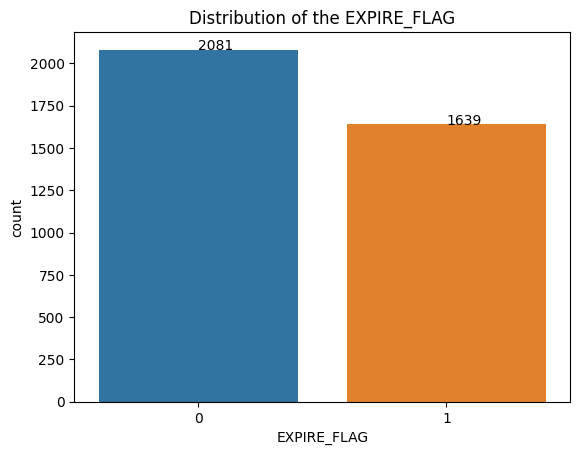

In [ ]:
#distribution of the EXPIRE_FLAG: 0 and 1
#we can see that the ratio of sample death to survival
y=[2081,1639]
fig, ax = plt.subplots()
sns.countplot(data=df, x='EXPIRE_FLAG')
for i,v in enumerate(y):
 ax.text(i,v+1,str(v))
plt.title("Distribution of the EXPIRE_FLAG")
plt.show()


<ipython-input-64-ff2ce59db87b>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  co = df.corr()


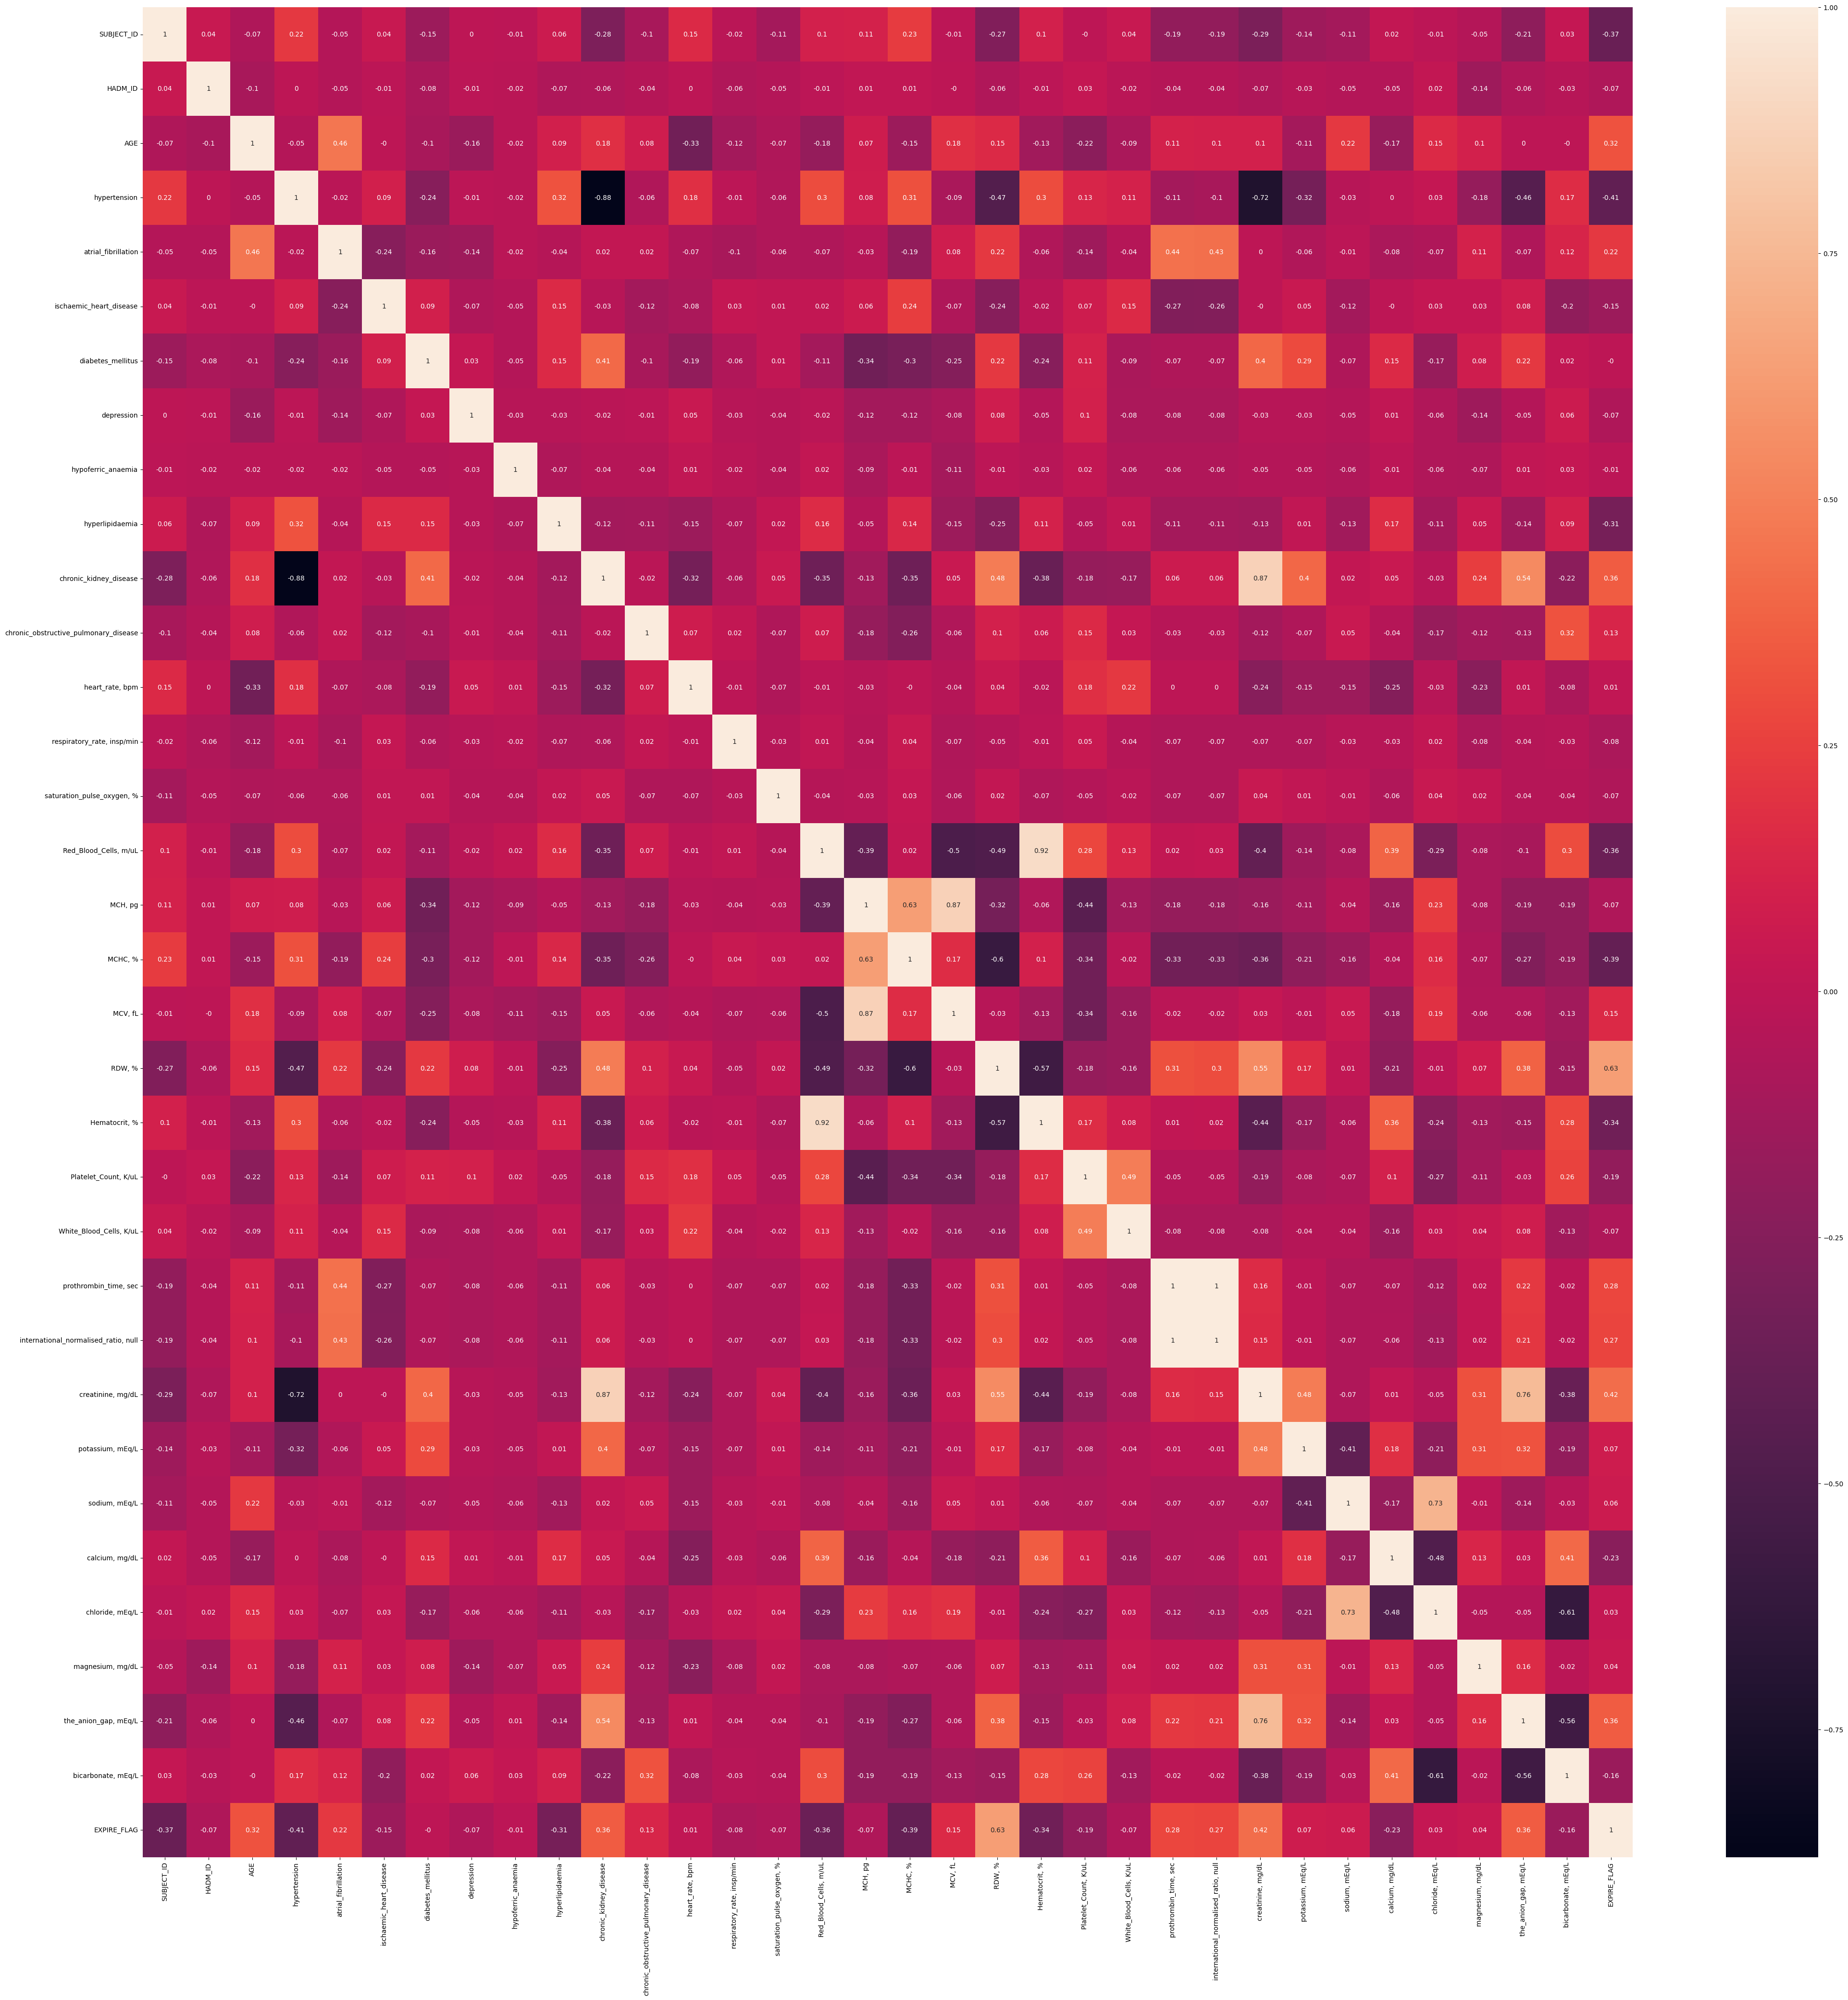

In [ ]:
#corelation matrix map
#From the corelation map below, we can see there are some features highly corelated, which could be removed to lower the feature dimension
co = df.corr()
plt.subplots(figsize=(50, 50))
sns.heatmap(co.corr().round(2),annot=True)
plt.show()

##Analysing patient's demographic characteristics

GENDER  EXPIRE_FLAG
F       0               951
        1               779
M       0              1130
        1               860
Name: EXPIRE_FLAG, dtype: int64


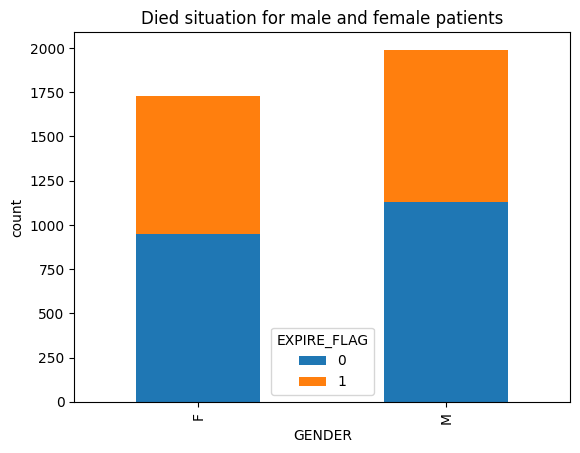

In [ ]:
#From the bar below ,we can observe that the mortality rate of males and females is equal.
#It can be speculated that the mortality rate and gender are not very related. 
#We can discard this feature

data=df.groupby(['GENDER','EXPIRE_FLAG'])
data=data['EXPIRE_FLAG'].count()
print(data)
data=data.unstack()
data.plot(kind='bar',stacked='True')
plt.title("Died situation for male and female patients")
plt.ylabel('count')
plt.show()

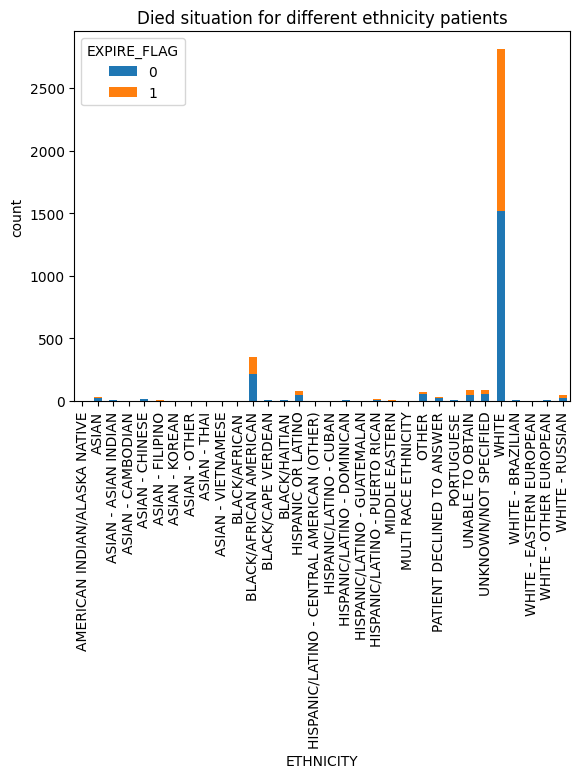

In [ ]:
#From the bar below,we can see that the proportion of white patients in the sample patients is the highest, 
#and the samples of other races are too small, so we think that the enthnicity feature are not meaningful
data=df.groupby(['ETHNICITY','EXPIRE_FLAG'])
data=data['EXPIRE_FLAG'].count()
data=data.unstack()
data.plot(kind='bar',stacked='True')
plt.title("Died situation for different ethnicity patients")
plt.ylabel('count')
plt.show()

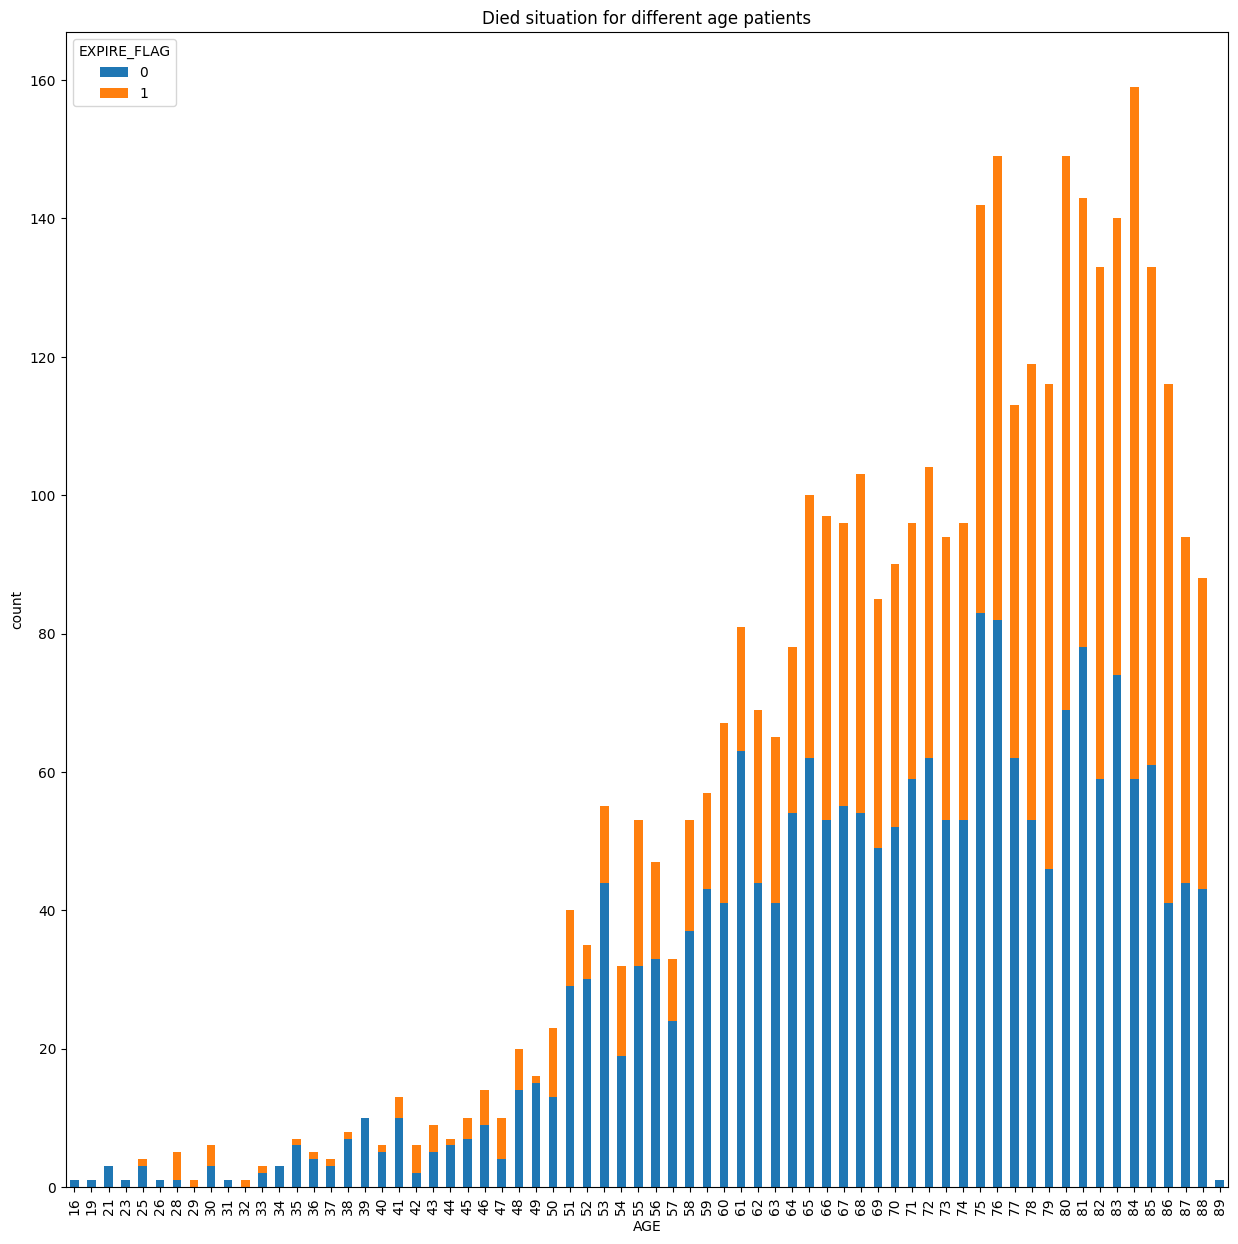

In [ ]:
#From the bar below，we can see that older patients have a higher mortality rate depending on age
data=df.groupby(['AGE','EXPIRE_FLAG'])
data=data['AGE'].count()
data=data.unstack()

data.plot(kind='bar',stacked='True',figsize=(15, 15))
plt.title("Died situation for different age patients")
plt.ylabel('count')
plt.show()


##Analysing patient's comorbidities

In [ ]:
df_comorbidities=df.loc[:,['SUBJECT_ID','hypertension','atrial_fibrillation','ischaemic_heart_disease','diabetes_mellitus','depression','hypoferric_anaemia','hyperlipidaemia','chronic_kidney_disease','chronic_obstructive_pulmonary_disease','EXPIRE_FLAG']]
df_comorbidities.head()
df_comorbidities.shape

(3720, 11)

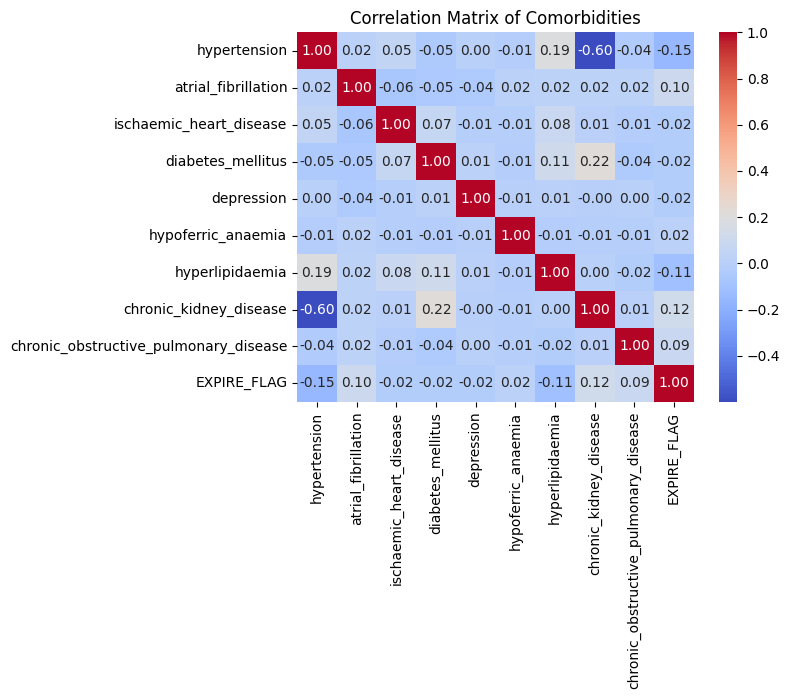

Linear Regression Coefficients:  [ 0.15803611  0.23462882  0.06745297  0.06525211  0.06069633  0.76537118
 -0.02215907  0.31281034  0.19626125]


In [ ]:
#Correlation strength: The color in the correlation matrix represents the strength of the correlation between different comorbidities. 
#The darker the color, the stronger the correlation; the lighter the color, the weaker the correlation.
#Positive and negative correlation: The color of the square in the correlation matrix represents the direction of the correlation. 
#Red represents positive correlation, which means that two comorbidities show a similar trend, i.e., hypertension and chronic_obstructive_pulmonary_disease have positive correlation with EXPIRE_FLAG.
#Blue represents negative correlation, which means that two comorbidities show opposite trends, i.e., atrial_fibrillation and hyperlipidaemia have negative correlation with EXPIRE_FLAG
columns = ["hypertension", "atrial_fibrillation", "ischaemic_heart_disease", "diabetes_mellitus","depression","hypoferric_anaemia","hyperlipidaemia","chronic_kidney_disease","chronic_obstructive_pulmonary_disease","EXPIRE_FLAG"]
corr_matrix = df[columns].corr()
#heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Matrix of Comorbidities')
plt.show()

#linear regression coefficients
X = df[['hypertension', 'atrial_fibrillation',"ischaemic_heart_disease", "diabetes_mellitus","depression","hypoferric_anaemia","hyperlipidaemia","chronic_kidney_disease","chronic_obstructive_pulmonary_disease"]]
y = df['EXPIRE_FLAG']
reg = np.linalg.lstsq(X, y, rcond=None)[0]
print('Linear Regression Coefficients: ', reg)
#accoring to the coefficients we can find hypoferric_anaemia have the highest value 

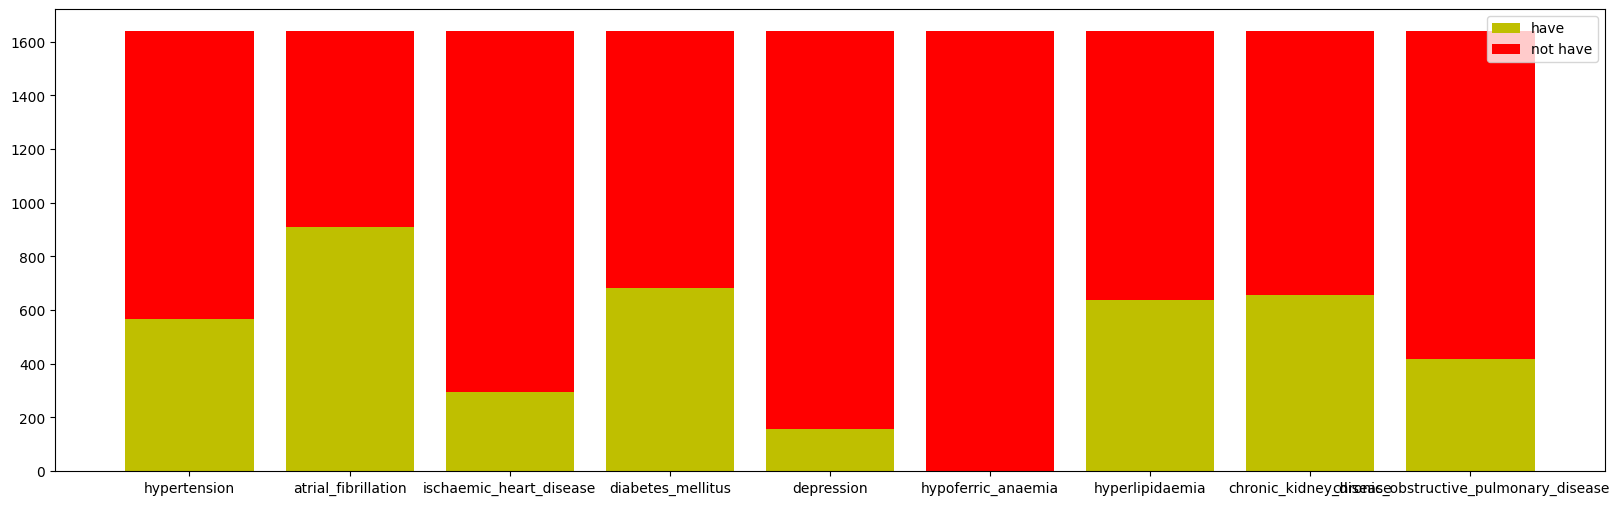

In [ ]:
#Show the comorbidities situation for died patients,we can see that some complications are highly correlated with death, some like hypoferric_anaemia were not 
# comorData=df_comorbidities.loc[df_comorbidities['EXPIRE_FLAG'] == 1]
# comorData.shape
# # data.head()
# hypertension=comorData['hypertension'].value_counts()
# atrial_fibrillation=comorData['atrial_fibrillation'].value_counts()
# ischaemic_heart_disease=comorData['ischaemic_heart_disease'].value_counts()
# diabetes_mellitus=comorData['diabetes_mellitus'].value_counts()
# depression=comorData['depression'].value_counts()
# hypoferric_anaemia=comorData['hypoferric_anaemia'].value_counts()
# hyperlipidaemia=comorData['hyperlipidaemia'].value_counts()
# chronic_kidney_disease=comorData['chronic_kidney_disease'].value_counts()
# chronic_obstructive_pulmonary_disease=comorData['chronic_obstructive_pulmonary_disease'].value_counts()

# plt.figure(figsize=(20, 6))
# name_list = ["hypertension", "atrial_fibrillation", "ischaemic_heart_disease", "diabetes_mellitus","depression","hypoferric_anaemia","hyperlipidaemia","chronic_kidney_disease","chronic_obstructive_pulmonary_disease"]
# num_list = [1073,909,1344,957,1481,1638,1001,983,1221]
# num_list1 = [566,730,295,682,158,1,683,656,418]
# plt.bar(range(len(num_list)), num_list, label='have',fc = 'y')
# plt.bar(range(len(num_list)), num_list1, bottom=num_list, label='not have',tick_label = name_list,fc = 'r')
# plt.legend()
# plt.show()

comorData = df_comorbidities.loc[df_comorbidities['EXPIRE_FLAG'] == 1]

comorbidities = ['hypertension', 'atrial_fibrillation', 'ischaemic_heart_disease', 'diabetes_mellitus',
                 'depression', 'hypoferric_anaemia', 'hyperlipidaemia', 'chronic_kidney_disease',
                 'chronic_obstructive_pulmonary_disease']

comorbidity_counts = [comorData[comorbidity].value_counts() for comorbidity in comorbidities]

plt.figure(figsize=(20, 6))
plt.bar(range(len(comorbidity_counts)), [count[1] for count in comorbidity_counts], label='have', fc='y')
plt.bar(range(len(comorbidity_counts)), [count[0] for count in comorbidity_counts], bottom=[count[1] for count in comorbidity_counts], 
        label='not have', tick_label=comorbidities, fc='r')
plt.legend()
plt.show()

##Analysing patient's Vital Signal & Lab Variables

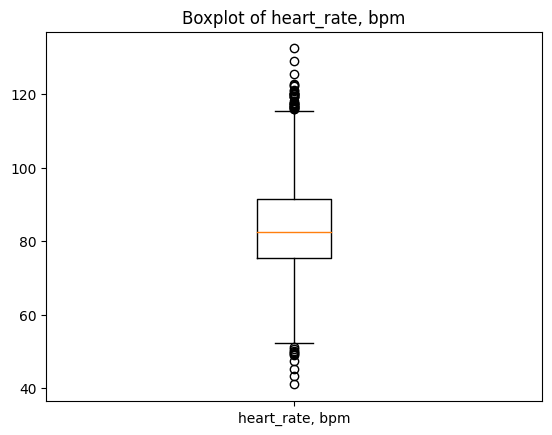

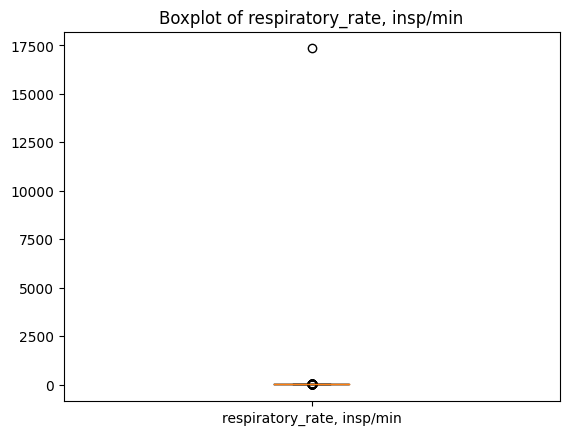

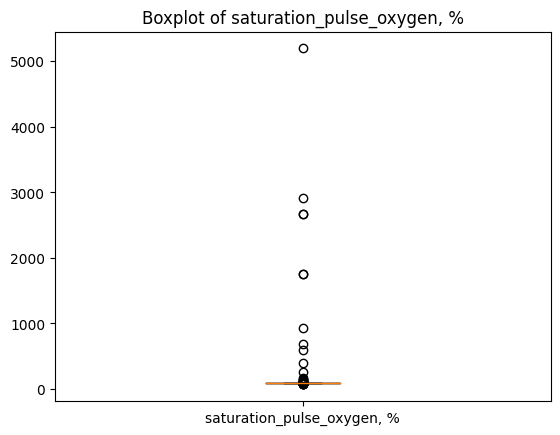

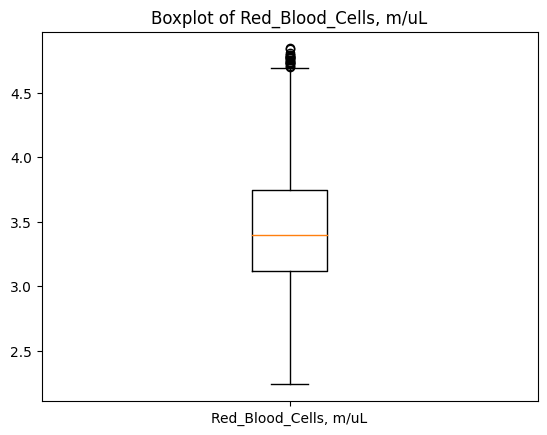

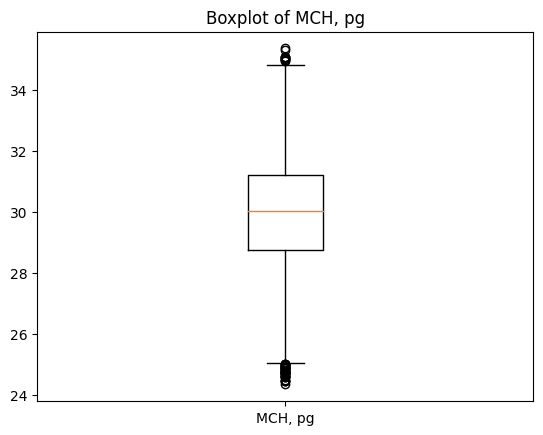

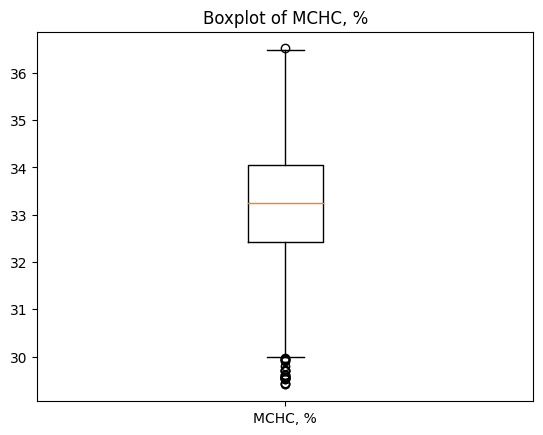

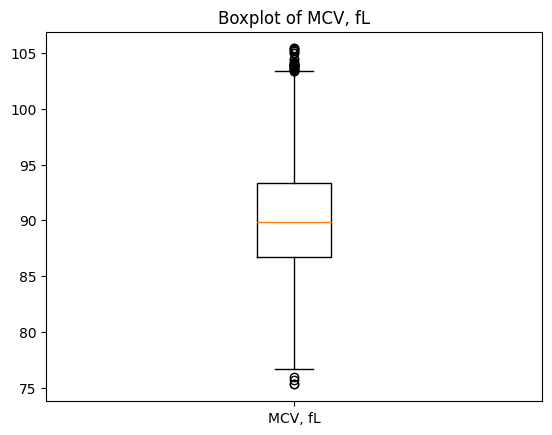

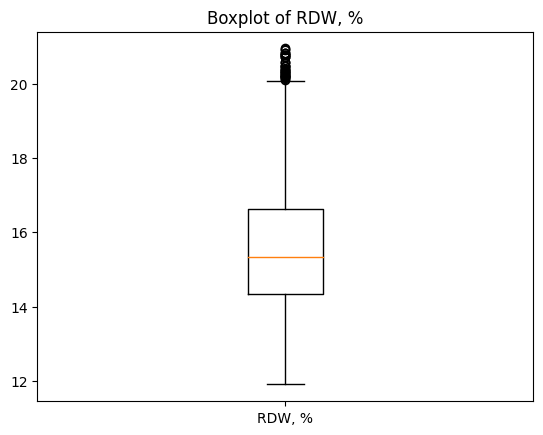

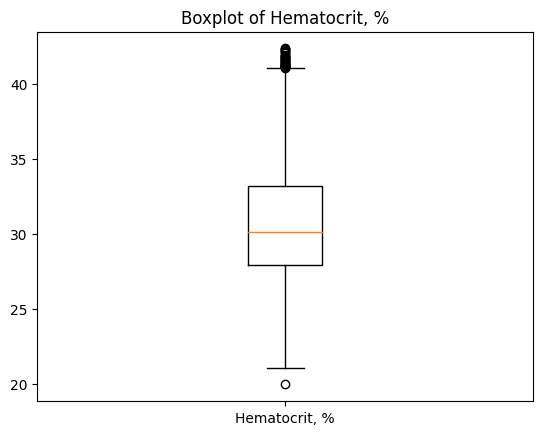

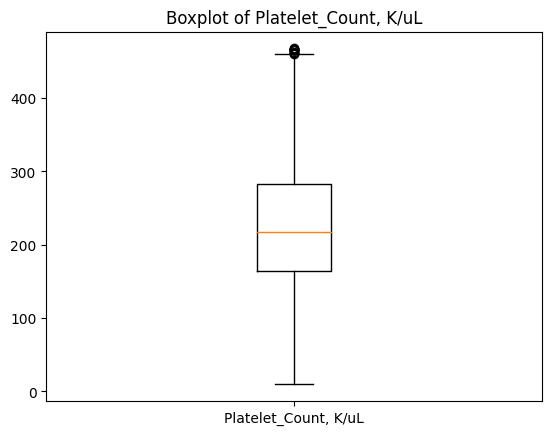

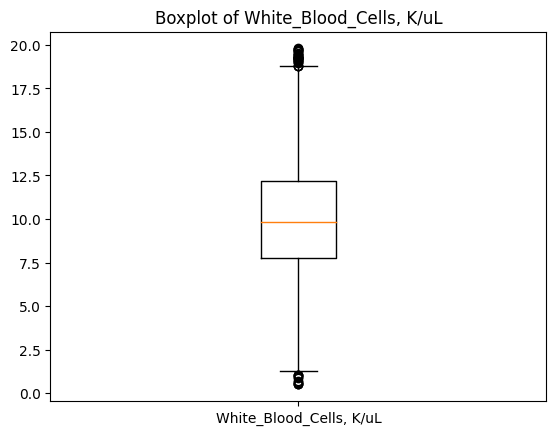

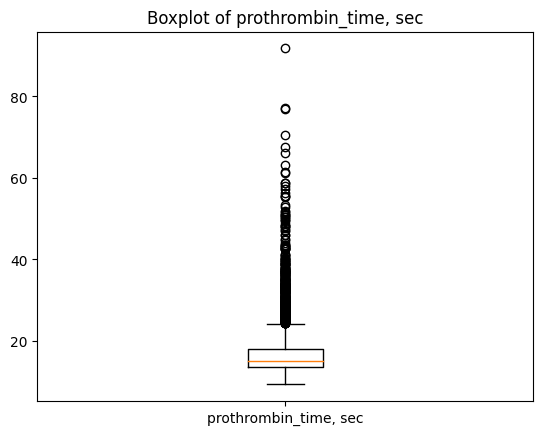

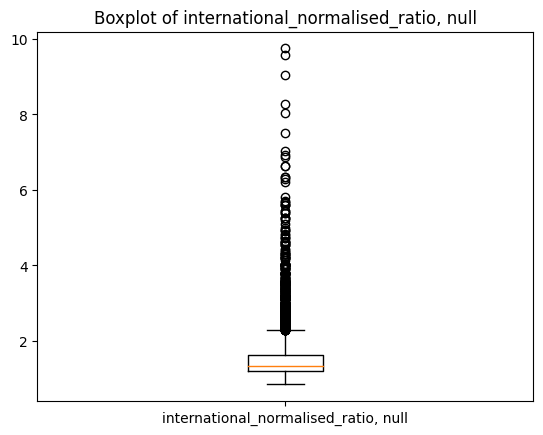

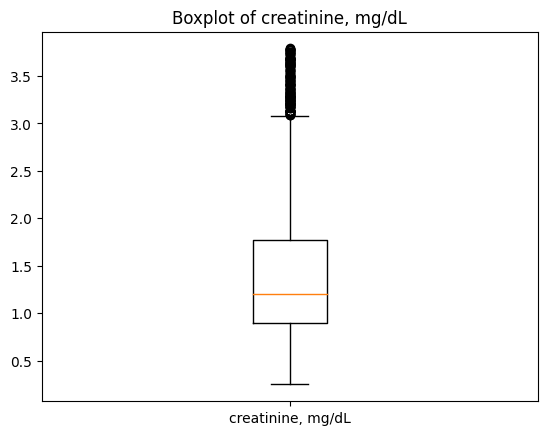

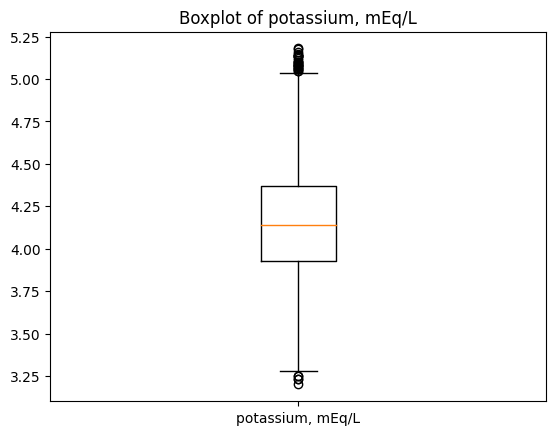

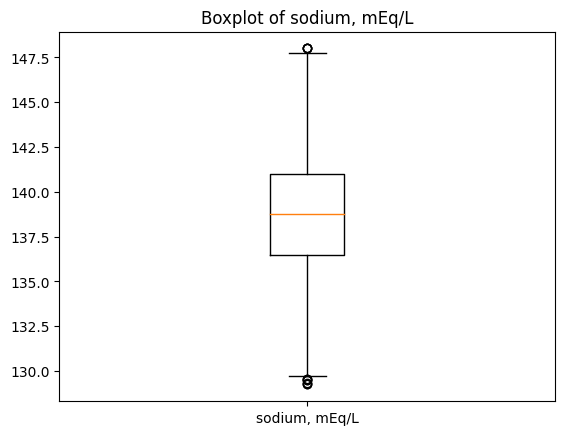

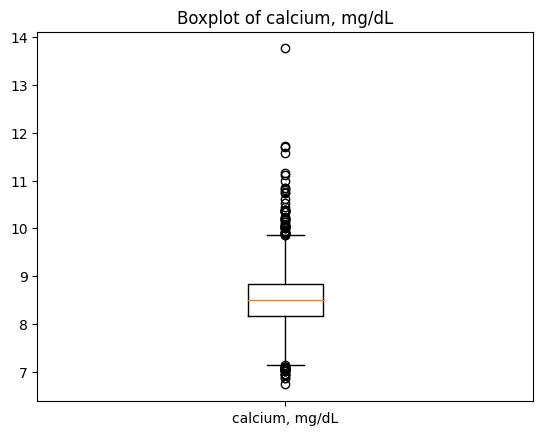

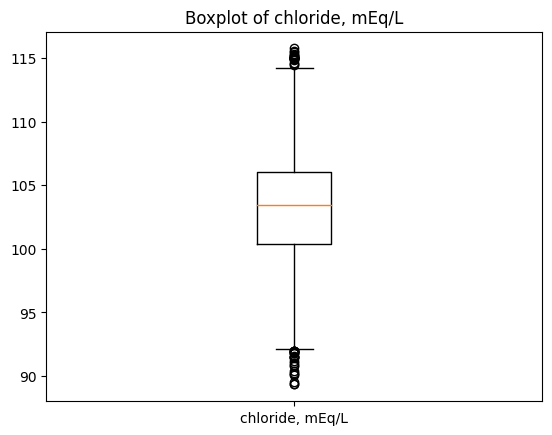

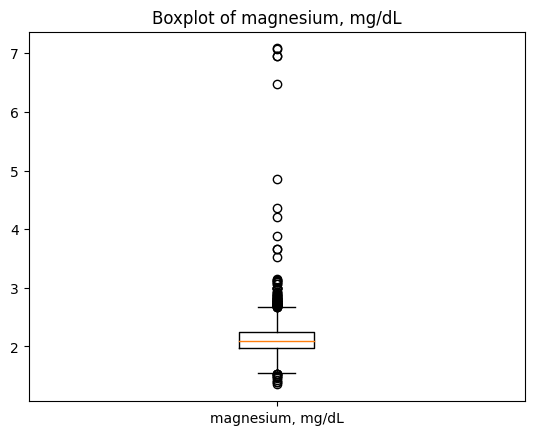

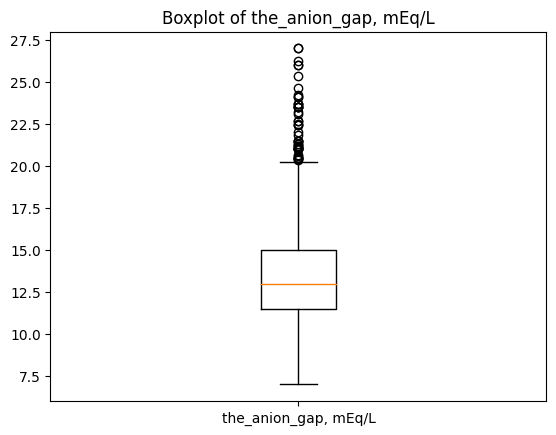

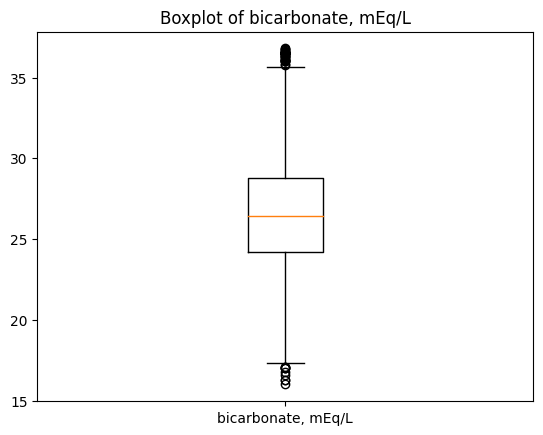

In [ ]:
#
labels = ['heart_rate, bpm', 'respiratory_rate, insp/min', 'saturation_pulse_oxygen, %', 'Red_Blood_Cells, m/uL', 'MCH, pg', 'MCHC, %', 'MCV, fL', 'RDW, %', 'Hematocrit, %', 'Platelet_Count, K/uL', 'White_Blood_Cells, K/uL', 'prothrombin_time, sec', 'international_normalised_ratio, null', 'creatinine, mg/dL', 'potassium, mEq/L', 'sodium, mEq/L', 'calcium, mg/dL', 'chloride, mEq/L', 'magnesium, mg/dL', 'the_anion_gap, mEq/L', 'bicarbonate, mEq/L']

for label in labels:
    plt.figure() 
    plt.title(f'Boxplot of {label}')
    plt.boxplot(df[label], labels=[label])
    plt.show()




##XGBoost

In [ ]:
!pip3 install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
X=data.iloc[:,4:-1]
Y=data.iloc[:,-1]
X.shape
# Y.shape



(3720, 31)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
  X, Y, test_size=0.2, random_state=42)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
param = {
    'max_depth': 3,
    'eta': 0.3,  
    'objective': 'multi:softmax', 
    'num_class': 3} 
num_round = 5 

In [ ]:
model = xgb.train(param, dtrain, num_round)

In [ ]:
y_predict = model.predict(dtest)
accuracy = accuracy_score(y_test, y_predict)
accuracy

0.6868279569892473

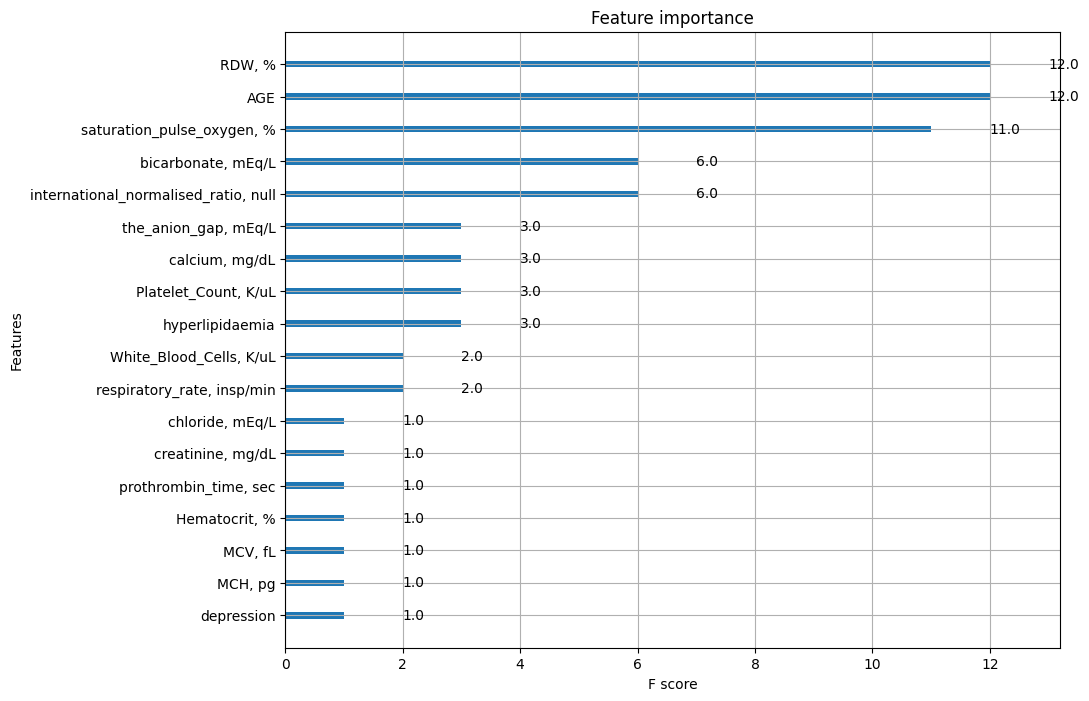

In [ ]:
#use XGboost to print the feature importance ranking.
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(model, ax=ax)
plt.show()

In [ ]:
feature_Selected=data.loc[:, ['SUBJECT_ID','HADM_ID','RDW, %', 'AGE','saturation_pulse_oxygen, %','bicarbonate, mEq/L','international_normalised_ratio, null','the_anion_gap, mEq/L','calcium, mg/dL','Platelet_Count, K/uL','hyperlipidaemia','White_Blood_Cells, K/uL','respiratory_rate, insp/min','EXPIRE_FLAG']]

In [ ]:
# #dataset after feature selected
# feature_Selected.to_csv('/content/drive/MyDrive/DA_Project/featureSelected_dataset.csv', index = False)

#Part 4 Modeling

###Data Loading

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DA_Project/featureSelected_dataset.csv')
data.head(5)

,SUBJECT_ID,HADM_ID,"RDW, %",AGE,"saturation_pulse_oxygen, %","bicarbonate, mEq/L","international_normalised_ratio, null","the_anion_gap, mEq/L","calcium, mg/dL","Platelet_Count, K/uL",hyperlipidaemia,"White_Blood_Cells, K/uL","respiratory_rate, insp/min",EXPIRE_FLAG
0,69778,185867,12.650,86,96.25,24.000,1.500,16.000,8.500,164.500,1,7.250,17.382,1
1,98139,195771,16.020,79,94.75,29.167,1.333,12.750,9.300,233.600,0,9.340,18.444,1
2,54604,126129,18.872,72,95.00,27.000,1.300,23.667,8.461,99.250,1,17.447,25.043,1
3,54604,126129,18.872,72,95.00,27.000,1.300,23.667,8.461,99.250,1,17.447,25.043,1
4,12008,162597,18.114,60,95.00,28.167,1.333,16.000,9.175,288.429,0,12.557,14.727,1


In [ ]:
data.shape

(3720, 14)

In [ ]:
expire_flag_counts = data["EXPIRE_FLAG"].value_counts()

print('Number of 0\'s:', expire_flag_counts[0])
print('Number of 1\'s:', expire_flag_counts[1])

Number of 0's: 2081
Number of 1's: 1639


In [ ]:
X = data.iloc[:,2:-1]
X.head(5)

,"RDW, %",AGE,"saturation_pulse_oxygen, %","bicarbonate, mEq/L","international_normalised_ratio, null","the_anion_gap, mEq/L","calcium, mg/dL","Platelet_Count, K/uL",hyperlipidaemia,"White_Blood_Cells, K/uL","respiratory_rate, insp/min"
0,12.650,86,96.25,24.000,1.500,16.000,8.500,164.500,1,7.250,17.382
1,16.020,79,94.75,29.167,1.333,12.750,9.300,233.600,0,9.340,18.444
2,18.872,72,95.00,27.000,1.300,23.667,8.461,99.250,1,17.447,25.043
3,18.872,72,95.00,27.000,1.300,23.667,8.461,99.250,1,17.447,25.043
4,18.114,60,95.00,28.167,1.333,16.000,9.175,288.429,0,12.557,14.727


In [ ]:
y = data.iloc[:,-1]
y.head(5)

#y containing the target variable EXPIRE_FLAG by selecting the last column of the data DataFrame using .iloc[] method.

0    1
1    1
2    1
3    1
4    1
Name: EXPIRE_FLAG, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

###DecisionTree

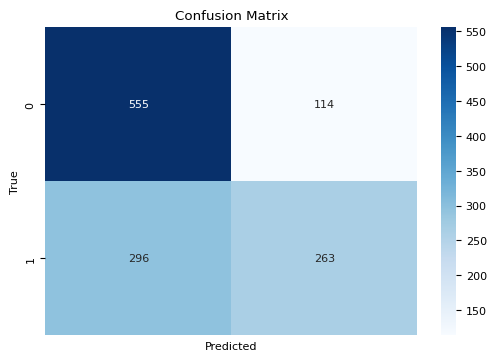

Decision Tree Classifier:
dt ROC AUC  Score: 0.7164900486936153
dt Accuracy Score: 0.6661237785016286
dt Sensitivity Score: 0.47048300536672627
dt Specificity Score: 0.8295964125560538
dt 10-fold cross-validation ROC AUC: 0.7040209704510224
dt 10-fold cross-validation Accuracy: 0.6657397590361446
dt 10-fold cross-validation Balanced Accuracy: 0.650578252810797
dt 10-fold cross-validation Recall: 0.537037037037037
dt 10-fold cross-validation Precision: 0.6384050010358654
dt 10-fold cross-validation F1 Score: 0.5802635200423579


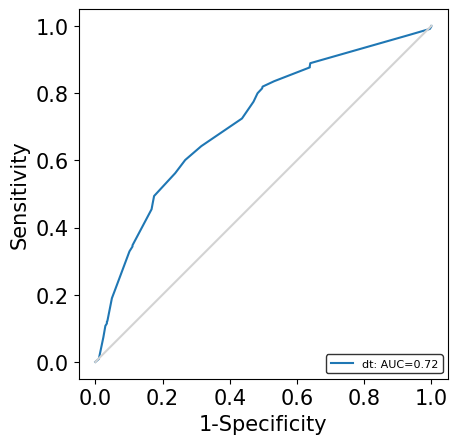

In [ ]:
#hyperparameter
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#decision tree
dt = DecisionTreeClassifier(random_state=42)

# Grid search
grid_search = GridSearchCV(dt, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Train the model with the best hyperparameters
dt = DecisionTreeClassifier(**grid_search.best_params_)
dt.fit(X_train, y_train)


y_pred = dt.predict(X_test)
y_probs = dt.predict_proba(X_test)[:, 1]
confusion = confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
AUC = roc_auc_score(y_test, y_probs)
ACC = accuracy_score(y_test, y_pred)
Sen = TP / float(TP+FN)
Spe = TN / float(TN+FP)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d', xticklabels=0, yticklabels=1)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Decision Tree Classifier:")
print(f'dt ROC AUC  Score: {AUC}')
print(f'dt Accuracy Score: {ACC}')
print(f'dt Sensitivity Score: {Sen}')
print(f'dt Specificity Score: {Spe}')



dt_scores = cross_validate(dt, X_train, y_train, cv=10, scoring = ['roc_auc', 'accuracy', 'balanced_accuracy', 'recall', 'precision', 'f1'], return_train_score = True)

print("dt 10-fold cross-validation ROC AUC: %s" % (dt_scores['test_roc_auc'].mean()))
print("dt 10-fold cross-validation Accuracy: %s" % (dt_scores['test_accuracy'].mean()))
print("dt 10-fold cross-validation Balanced Accuracy: %s" % (dt_scores['test_balanced_accuracy'].mean()))
print("dt 10-fold cross-validation Recall: %s" % (dt_scores['test_recall'].mean()))
print("dt 10-fold cross-validation Precision: %s" % (dt_scores['test_precision'].mean()))
print("dt 10-fold cross-validation F1 Score: %s" % (dt_scores['test_f1'].mean()))


dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, y_probs, pos_label=None, sample_weight=None, drop_intermediate=True)
dt_auc = roc_auc_score(y_test, y_probs)
plt.plot(dt_fpr, dt_tpr, label='dt: AUC={0:0.2f}'.format(dt_auc))
plt.xlabel('1-Specificity', fontsize=15)
plt.ylabel('Sensitivity', fontsize=15)
plt.axis('square')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0,1], [0,1], ls = '-', c = 'lightgrey')
plt.rcParams.update({'font.size': 8})
plt.legend(loc="lower right", edgecolor='black')
plt.show()


###RandomForest

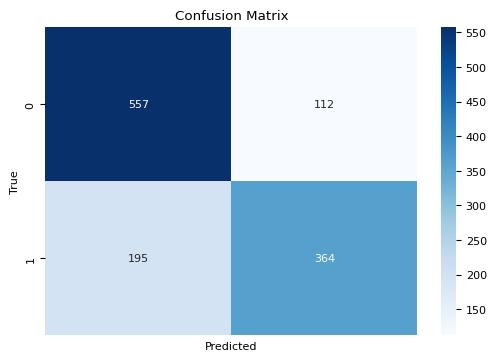

rf ROC AUC  Score: 0.8222856852536694
rf Accuracy Score: 0.75
rf Sensitivity Score: 0.6511627906976745
rf Specificity Score: 0.8325859491778774
rf 10-fold cross-validation ROC AUC: 0.8006835998919707
rf 10-fold cross-validation Accuracy: 0.7275421686746988
rf 10-fold cross-validation Balanced Accuracy: 0.7177496420604003
rf 10-fold cross-validation Recall: 0.6444444444444445
rf 10-fold cross-validation Precision: 0.7030151365255346
rf 10-fold cross-validation F1 Score: 0.6715689930930946


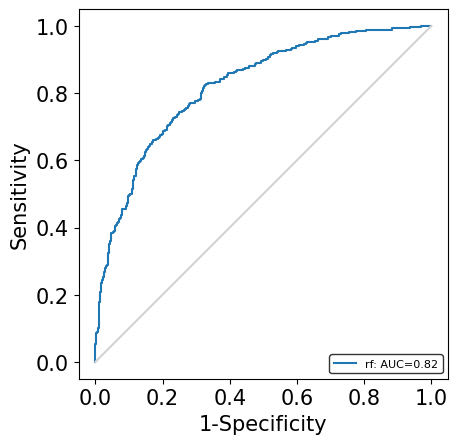

In [ ]:

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest classifier
rf = RandomForestClassifier()

#grid search for finding the best hyperparameters
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, y_train)
# print("Best Hyperparameters:", grid_search.best_params_)

# Train the model on the training set with the best hyperparameters
rf = RandomForestClassifier(**grid_search.best_params_)
rf.fit(X_train, y_train)

rf_predictions = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]
confusion = confusion_matrix(y_test, rf_predictions)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
AUC = roc_auc_score(y_test, rf_probs)
ACC = accuracy_score(y_test, rf_predictions)
Sen = TP / float(TP+FN)
Spe = TN / float(TN+FP)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d', xticklabels=0, yticklabels=1)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'rf ROC AUC  Score: {AUC}')
print(f'rf Accuracy Score: {ACC}')
print(f'rf Sensitivity Score: {Sen}')
print(f'rf Specificity Score: {Spe}')

rf_scores = cross_validate(rf, X_train, y_train, cv=10, scoring = ['roc_auc', 'accuracy', 'balanced_accuracy', 'recall', 'precision', 'f1'], return_train_score = True)
print("rf 10-fold cross-validation ROC AUC: %s" % (rf_scores['test_roc_auc'].mean()))
print("rf 10-fold cross-validation Accuracy: %s" % (rf_scores['test_accuracy'].mean()))
print("rf 10-fold cross-validation Balanced Accuracy: %s" % (rf_scores['test_balanced_accuracy'].mean()))
print("rf 10-fold cross-validation Recall: %s" % (rf_scores['test_recall'].mean()))
print("rf 10-fold cross-validation Precision: %s" % (rf_scores['test_precision'].mean()))
print("rf 10-fold cross-validation F1 Score: %s" % (rf_scores['test_f1'].mean()))

rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_probs, pos_label=None, sample_weight=None, drop_intermediate=True)
rf_auc = roc_auc_score(y_test, rf_probs)
plt.plot(rf_fpr, rf_tpr, label='rf: AUC={0:0.2f}'.format(rf_auc))
plt.xlabel('1-Specificity', fontsize=15)
plt.ylabel('Sensitivity', fontsize=15)
plt.axis('square')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0,1], [0,1], ls = '-', c = 'lightgrey')
plt.rcParams.update({'font.size': 8})
plt.legend(loc="lower right", edgecolor='black')
plt.show()


###XGBoost


Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500, 'scale_pos_weight': 1}


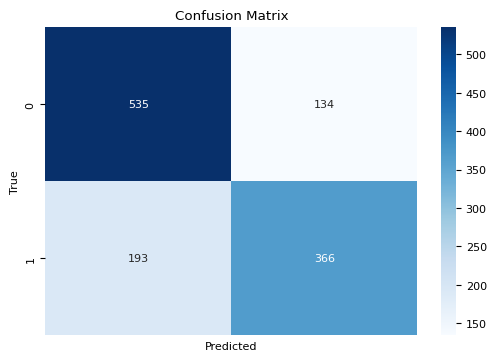

XGB ROC AUC  Score: 0.8025782747860128
XGB Accuracy Score: 0.7337133550488599
XGB Sensitivity Score: 0.6547406082289803
XGB Specificity Score: 0.7997010463378177
XGB 10-fold cross-validation ROC AUC: 0.7763443082979095
XGB 10-fold cross-validation Accuracy: 0.6986489959839357
XGB 10-fold cross-validation Balanced Accuracy: 0.6875810219869256
XGB 10-fold cross-validation Recall: 0.6046296296296296
XGB 10-fold cross-validation Precision: 0.669709450025356
XGB 10-fold cross-validation F1 score: 0.6341359152099063


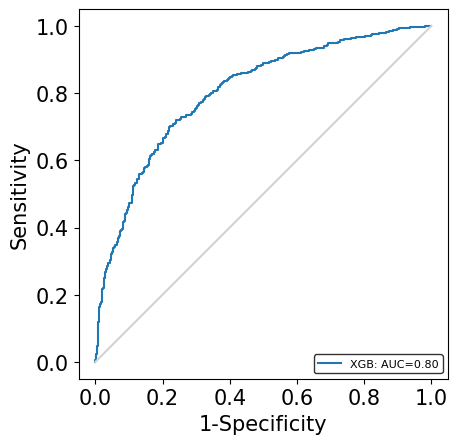

In [ ]:

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 1],
    'scale_pos_weight': [1, 10, 100]
}


xgb = XGBClassifier()
grid_search = GridSearchCV(xgb, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

# Train the model with the best hyperparameters
xgb = XGBClassifier(**grid_search.best_params_)
xgb.fit(X_train, y_train)
xgb_predictions = xgb.predict(X_test)
xgb_probs = xgb.predict_proba(X_test)[:, 1]

# Evaluatation
confusion = confusion_matrix(y_test, xgb_predictions)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
AUC = roc_auc_score(y_test, xgb_probs)
ACC = accuracy_score(y_test, xgb_predictions)
Sen = TP / float(TP+FN)
Spe = TN / float(TN+FP)

plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d', xticklabels=0, yticklabels=1)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


print(f'XGB ROC AUC  Score: {AUC}') # print ROC AUC score
print(f'XGB Accuracy Score: {ACC}') # print accuracy score
print(f'XGB Sensitivity Score: {Sen}') # print sensitivity score
print(f'XGB Specificity Score: {Spe}') # print specificity score


xgb_scores = cross_validate(xgb, X_train, y_train, cv=10, scoring = ['roc_auc', 'accuracy', 'balanced_accuracy', 'recall', 'precision', 'f1'], return_train_score = True)
print("XGB 10-fold cross-validation ROC AUC: %s" % (xgb_scores['test_roc_auc'].mean()))
print("XGB 10-fold cross-validation Accuracy: %s" % (xgb_scores['test_accuracy'].mean()))
print("XGB 10-fold cross-validation Balanced Accuracy: %s" % (xgb_scores['test_balanced_accuracy'].mean()))
print("XGB 10-fold cross-validation Recall: %s" % (xgb_scores['test_recall'].mean()))
print("XGB 10-fold cross-validation Precision: %s" % (xgb_scores['test_precision'].mean())) # print precision score
print("XGB 10-fold cross-validation F1 score: %s" % (xgb_scores['test_f1'].mean())) # print F1 score


# Plot
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_probs, pos_label=None, sample_weight=None, drop_intermediate=True)
xgb_auc = roc_auc_score(y_test, xgb_probs)
plt.plot(xgb_fpr, xgb_tpr, label='XGB: AUC={0:0.2f}'.format(xgb_auc))
plt.xlabel('1-Specificity', fontsize=15)
plt.ylabel('Sensitivity', fontsize=15)
plt.axis('square')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0,1], [0,1], ls = '-', c = 'lightgrey')
plt.rcParams.update({'font.size': 8})
plt.legend(loc="lower right", edgecolor='black')
plt.show()


###Gradient Boosting classifier

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.75}


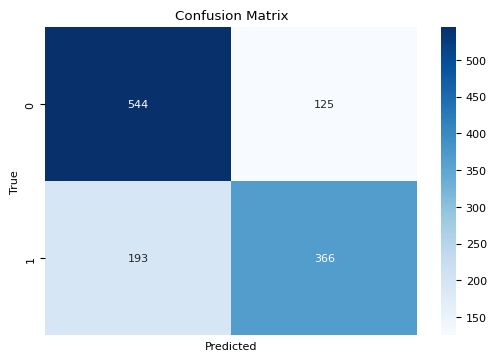

GBC ROC AUC  Score: 0.82040586034746
GBC Accuracy Score: 0.741042345276873
GBC Sensitivity Score: 0.6547406082289803
GBC Specificity Score: 0.8131539611360239
GBC 10-fold cross-validation ROC AUC: 0.7980038161725805
GBC 10-fold cross-validation Accuracy: 0.7195148594377511
GBC 10-fold cross-validation Balanced Accuracy: 0.708389521526321
GBC 10-fold cross-validation Recall: 0.6249999999999999
GBC 10-fold cross-validation Precision: 0.6974558603032343
GBC 10-fold cross-validation F1 score: 0.6582924597169176


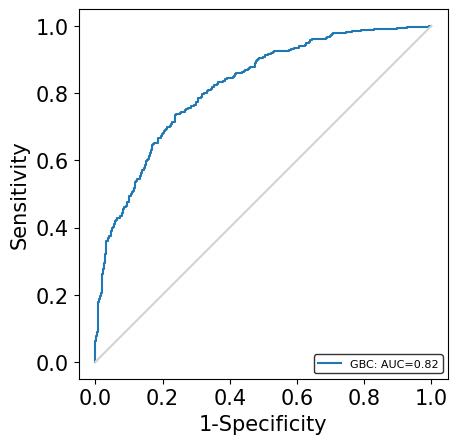

In [ ]:

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 1],
    'subsample': [0.5, 0.75, 1.0]
}

gbc = GradientBoostingClassifier()
grid_search = GridSearchCV(gbc, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

# Train with the best hyperparameters
gbc = GradientBoostingClassifier(**grid_search.best_params_)
gbc.fit(X_train, y_train)
gbc_predictions = gbc.predict(X_test)
gbc_probs = gbc.predict_proba(X_test)[:, 1]

# Evaluating
confusion = confusion_matrix(y_test, gbc_predictions)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
AUC = roc_auc_score(y_test, gbc_probs)
ACC = accuracy_score(y_test, gbc_predictions)
Sen = TP / float(TP+FN)
Spe = TN / float(TN+FP)

plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d', xticklabels=0, yticklabels=1)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


print(f'GBC ROC AUC  Score: {AUC}') # print ROC AUC score
print(f'GBC Accuracy Score: {ACC}') # print accuracy score
print(f'GBC Sensitivity Score: {Sen}') # print sensitivity score
print(f'GBC Specificity Score: {Spe}') # print specificity score

gbc_scores = cross_validate(gbc, X_train, y_train, cv=10, scoring = ['roc_auc', 'accuracy', 'balanced_accuracy', 'recall', 'precision', 'f1'], return_train_score = True)
print("GBC 10-fold cross-validation ROC AUC: %s" % (gbc_scores['test_roc_auc'].mean()))
print("GBC 10-fold cross-validation Accuracy: %s" % (gbc_scores['test_accuracy'].mean()))
print("GBC 10-fold cross-validation Balanced Accuracy: %s" % (gbc_scores['test_balanced_accuracy'].mean()))
print("GBC 10-fold cross-validation Recall: %s" % (gbc_scores['test_recall'].mean()))
print("GBC 10-fold cross-validation Precision: %s" % (gbc_scores['test_precision'].mean())) # print precision score
print("GBC 10-fold cross-validation F1 score: %s" % (gbc_scores['test_f1'].mean())) # print F1 score

# Plot
gbc_fpr, gbc_tpr, gbc_thresholds = roc_curve(y_test, gbc_probs, pos_label=None, sample_weight=None, drop_intermediate=True)
gbc_auc = roc_auc_score(y_test, gbc_probs)
plt.plot(gbc_fpr, gbc_tpr, label='GBC: AUC={0:0.2f}'.format(gbc_auc))
plt.xlabel('1-Specificity', fontsize=15)
plt.ylabel('Sensitivity', fontsize=15)
plt.axis('square')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0,1], [0,1], ls = '-', c = 'lightgrey')
plt.rcParams.update({'font.size': 8})
plt.legend(loc="lower right", edgecolor='black')
plt.show()



###Comparsion

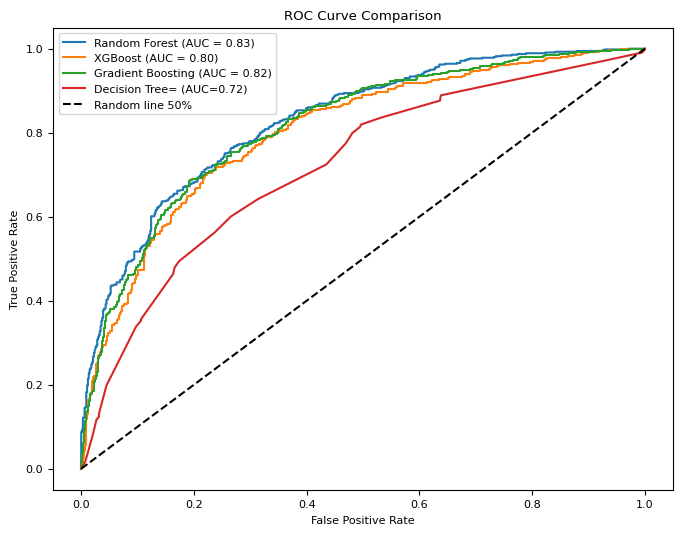

In [ ]:



# Plot all
plt.figure(figsize=(8, 6))

# Random Forest
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = {:.2f})'.format(rf_auc))

# XGBoost
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost (AUC = {:.2f})'.format(xgb_auc))

# Gradient Boosting
gbc_fpr, gbc_tpr, gbc_thresholds = roc_curve(y_test, gbc_probs)
gbc_auc = roc_auc_score(y_test, gbc_probs)
plt.plot(gbc_fpr, gbc_tpr, label='Gradient Boosting (AUC = {:.2f})'.format(gbc_auc))

# Decision Tree

dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, y_probs)
dt_auc = roc_auc_score(y_test, y_probs)
plt.plot(dt_fpr, dt_tpr, label='Decision Tree= (AUC={:.2f})'.format(dt_auc))


#random line 50%/50%
plt.plot([0, 1], [0, 1], 'k--', label='Random line 50%')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
plt.show()
